In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from functions import *
%matplotlib inline

In [343]:
#import data in question
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

,Start Date,End Date,ADP
0,2016-05-26,2016-06-24,9806.0
1,2016-06-25,2016-07-24,9764.0
2,2016-07-25,2016-08-23,9762.0
3,2016-08-24,2016-09-22,9863.0
4,2016-09-23,2016-10-22,9815.0


In [344]:
joined_doc_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_doc_ivs_df['Start Date'] = joined_doc_ivs_df['Start Date'].astype('datetime64[ns]')
joined_doc_ivs_df['End Date'] = joined_doc_ivs_df['End Date'].astype('datetime64[ns]')
joined_doc_ivs_df.head()

,Start Date,End Date,admission_count,discharge_count,Avg LOS Days
0,2016-05-26,2016-06-24,4905,5037,60.279683
1,2016-06-25,2016-07-24,4672,4554,61.474042
2,2016-07-25,2016-08-23,4770,4794,60.022083
3,2016-08-24,2016-09-22,4825,4719,57.456683
4,2016-09-23,2016-10-22,4535,4594,62.671013


In [345]:
crime_data = pd.read_csv("../Data/_30_day_crime_counts.csv", index_col = 0)
#specify data types for start and end date
crime_data['Start Date'] = crime_data['Start Date'].astype('datetime64[ns]')
crime_data['End Date'] = crime_data['End Date'].astype('datetime64[ns]')

#get arrest data
arrest_data = pd.read_csv("../Data/_30_day_arrest_counts.csv", index_col = 0)
#specify data types for start and end date
arrest_data['Start Date'] = arrest_data['Start Date'].astype('datetime64[ns]')
arrest_data['End Date'] = arrest_data['End Date'].astype('datetime64[ns]')


In [346]:
print(len(crime_data),len(arrest_data),len(joined_doc_ivs_df),len(_30day_pop_tot))

98 98 99 100


In [347]:
#join all variables of interest into one dataframe
crime_cols = ['Start Date', 'End Date', 'total_felony_crimes',
              'violent_felony_crimes','nonviolent_felony_crimes', 'total_misdemeanor_crimes']
arr_cols = ['Start Date', 'End Date', 'total_felony_arrest',
            'violent_felony_arrest','nonviolent_felony_arrest', 'total_misdemeanor_arrest']

#join adp and crime data
joined_df = _30day_pop_tot.merge(crime_data[crime_cols],
                                 how = 'left',
                                 left_on= ['Start Date', 'End Date'],
                                 right_on= ['Start Date', 'End Date'])
#join arrests
joined_df = joined_df.merge(arrest_data[arr_cols],
                                 how = 'left',
                                 left_on= ['Start Date', 'End Date'],
                                 right_on= ['Start Date', 'End Date'])
#join admission count
joined_df = joined_df.merge(joined_doc_ivs_df[['Start Date', 'End Date','admission_count']],
                            how = 'left',
                            left_on= ['Start Date', 'End Date'],
                            right_on= ['Start Date', 'End Date']
                            )
joined_df.head()

,Start Date,End Date,ADP,total_felony_crimes,violent_felony_crimes,nonviolent_felony_crimes,total_misdemeanor_crimes,total_felony_arrest,violent_felony_arrest,nonviolent_felony_arrest,total_misdemeanor_arrest,admission_count
0,2016-05-26,2016-06-24,9806.0,12664.0,3306.0,9358.0,23232.0,7734.0,2296.0,5438.0,17571.0,4905.0
1,2016-06-25,2016-07-24,9764.0,12997.0,3645.0,9352.0,22075.0,7504.0,2367.0,5137.0,15530.0,4672.0
2,2016-07-25,2016-08-23,9762.0,13078.0,3543.0,9535.0,22391.0,7870.0,2438.0,5432.0,16319.0,4770.0
3,2016-08-24,2016-09-22,9863.0,12897.0,3348.0,9549.0,21945.0,7902.0,2295.0,5607.0,16978.0,4825.0
4,2016-09-23,2016-10-22,9815.0,12684.0,3166.0,9518.0,21691.0,7886.0,2235.0,5651.0,17413.0,4535.0


In [348]:
joined_df.tail()

,Start Date,End Date,ADP,total_felony_crimes,violent_felony_crimes,nonviolent_felony_crimes,total_misdemeanor_crimes,total_felony_arrest,violent_felony_arrest,nonviolent_felony_arrest,total_misdemeanor_arrest,admission_count
95,2024-03-15,2024-04-13,6300.0,14059.0,3659.0,10400.0,22842.0,8461.0,2743.0,5718.0,11389.0,1948.0
96,2024-04-14,2024-05-13,6325.0,14700.0,3943.0,10757.0,23397.0,8713.0,2908.0,5805.0,11542.0,1951.0
97,2024-05-14,2024-06-12,6333.0,15199.0,4224.0,10975.0,24753.0,9551.0,3214.0,6337.0,12517.0,1983.0
98,2024-06-13,2024-07-12,6391.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0
99,2024-07-13,2024-08-11,6394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [349]:
joined_df.columns

Index(['Start Date', 'End Date', 'ADP', 'total_felony_crimes',
       'violent_felony_crimes', 'nonviolent_felony_crimes',
       'total_misdemeanor_crimes', 'total_felony_arrest',
       'violent_felony_arrest', 'nonviolent_felony_arrest',
       'total_misdemeanor_arrest', 'admission_count'],
      dtype='object')

Lets optimize the parameters for the crime variables and use a K-fold cross-validation to measure the chosen model's ability to accurately predict +1 and +12 forecasts.

In [350]:
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima.utils import ndiffs, nsdiffs

In [351]:
# Function to find the best SARIMA model based on AIC
def find_best_sarima(data, m=12):
    d = ndiffs(data.dropna(), test='adf')
    model = pm.auto_arima(data, seasonal=True, m=m, d=d, trace=False, error_action='ignore', suppress_warnings=True)
    return model

# Function to perform k-fold cross-validation and calculate MAE
def cross_val_mae(model, data, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae_scores = []

    for train_index, test_index in tscv.split(data):
        train, test = data[train_index], data[test_index]
        model.fit(train)
        # pmdarima's predict method takes n_periods instead of start and end
        n_periods = len(test)
        forecast = model.predict(n_periods=n_periods)
        mae_scores.append(mean_absolute_error(test, forecast))

    return sum(mae_scores) / len(mae_scores)


In [352]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import warnings

# Function to find the best SARIMA model based on AIC
def find_best_sarima(data, m=12):
    d = ndiffs(data.dropna(), test='adf')
    try:
        model = pm.auto_arima(data, seasonal=True, m=m, d=d, trace=False, error_action='ignore', suppress_warnings=True)
        return model
    except np.linalg.LinAlgError as e:
        print(f"Failed to fit model for data: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while fitting the model: {e}")
        return None

# Function to perform k-fold cross-validation and calculate MAE
def cross_val_mae(model, data, n_splits):
    if model is None:
        return np.nan
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae_scores = []

    for train_index, test_index in tscv.split(data):
        train, test = data[train_index], data[test_index]
        try:
            model.fit(train)
            n_periods = len(test)
            forecast = model.predict(n_periods=n_periods)
            mae_scores.append(mean_absolute_error(test, forecast))
        except np.linalg.LinAlgError as e:
            print(f"Error during fitting or prediction: {e}")
            return np.nan
        except Exception as e:
            print(f"An unexpected error occurred during fitting or prediction: {e}")
            return np.nan

    return sum(mae_scores) / len(mae_scores)

In [353]:
# Define the crime variables
crime_vars = ['total_felony_crimes', 'violent_felony_crimes', 'nonviolent_felony_crimes', 'total_misdemeanor_crimes']

# Find and evaluate SARIMA models for each crime variable
crime_models = {}

for var in crime_vars:
    data = joined_df[var].dropna()
    model = find_best_sarima(data)
    print(f"Done Modeling for {var}")
    mae = cross_val_mae(model, data, n_splits=7)
    print(f"Done k-fold cross validating for {var}")
    crime_models[var] = {'model': model, 'MAE': mae}


Done Modeling for total_felony_crimes
Done k-fold cross validating for total_felony_crimes
Done Modeling for violent_felony_crimes
Done k-fold cross validating for violent_felony_crimes
Done Modeling for nonviolent_felony_crimes
Done k-fold cross validating for nonviolent_felony_crimes
Done Modeling for total_misdemeanor_crimes
Done k-fold cross validating for total_misdemeanor_crimes


In [354]:
crime_models

{'total_felony_crimes': {'model': ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
        suppress_warnings=True),
  'MAE': 967.5580485169243},
 'violent_felony_crimes': {'model': ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
        suppress_warnings=True),
  'MAE': 263.98634462184475},
 'nonviolent_felony_crimes': {'model': ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12),
        suppress_warnings=True, with_intercept=False),
  'MAE': 785.5552459514927},
 'total_misdemeanor_crimes': {'model': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
        suppress_warnings=True, with_intercept=False),
  'MAE': 1603.464285714286}}

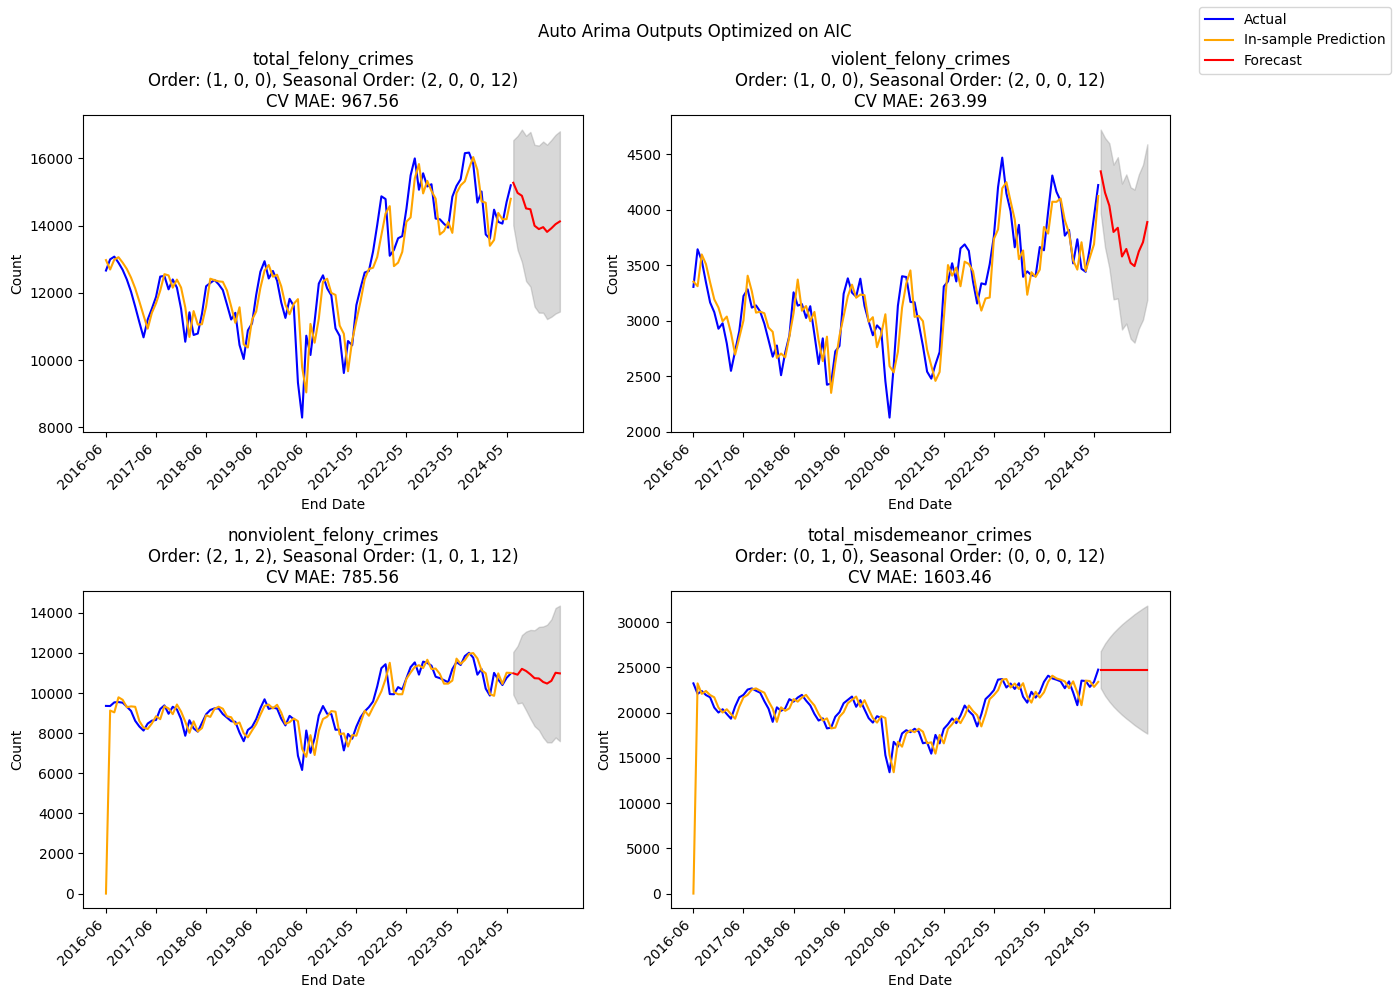

In [355]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each crime variable
for i, var in enumerate(crime_vars):
    ax = axes[i]
    data = joined_df[[var, 'End Date']].dropna()
    model = crime_models[var]['model']
    cv_mae = crime_models[var]['MAE']
    # Re-fit the model to the entire dataset
    model.fit(data[var])

    # In-sample prediction
    in_sample_pred = model.predict_in_sample()

    # Forecast for the next 12 steps
    forecast, conf_int = model.predict(n_periods=12, return_conf_int=True)

    # Plot the actual data
    ax.plot(data['End Date'], data[var], label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data['End Date'], in_sample_pred, label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1], periods=12, freq='M')
    ax.plot(future_dates, forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='grey', alpha=0.3)

    # Set title and labels, including model parameters
    title = f"{var}\nOrder: {model.order}, Seasonal Order: {model.seasonal_order}\nCV MAE: {round(cv_mae,2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    ax.set_xticks(data['End Date'][::12])
    ax.set_xticklabels(data['End Date'][::12].dt.strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Auto Arima Outputs Optimized on AIC")
# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.savefig("../Outputs/autoarima_kfold_cv_arrest_predictions.png", bbox_inches = 'tight')
plt.show()

Instead of relying on the auto_arima method to optimize the parameters of the model, I want to iterate through various options of potential p & q combinations, conduct the k-fold cross validation, and choose the model with the minimum mean absolute error of the 12 step prediction.

In [356]:
import itertools

In [357]:
def time_series_cv(y, order, seasonal_order, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae_scores = []

    for train_index, test_index in tscv.split(y):
        train, test = y[train_index], y[test_index]
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        
        predictions = results.predict(start=test_index[0], end=test_index[-1])
        mae = mean_absolute_error(test, predictions)
        mae_scores.append(mae)
        
    return results, np.mean(mae_scores)


def grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits):
    best_score, best_params = float("inf"), None
    
    d_value = ndiffs(y.dropna(), test='adf')
    D_value = nsdiffs(y.dropna(),m = 12)
    pdq = list(itertools.product(p_values, [d_value], q_values))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P_values, [D_value], Q_values))]
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                results, mae_score = time_series_cv(y, order=param, seasonal_order=param_seasonal, n_splits=n_splits)
                if mae_score < best_score:
                    best_score, best_params = mae_score, (param, param_seasonal)
                    best_result = results
            except:
                continue
    print(best_result.summary())
    return best_params, best_score

In [358]:
 # Suppress ARIMA convergence warnings
import warnings    
# Suppress all warnings (not recommended for production)
warnings.filterwarnings('ignore') 

In [359]:
# Define the ranges for the parameters
p_values = range(0, 3)
q_values = range(0, 3)
P_values = range(0, 2)
Q_values = range(0, 2)
s = 12  # Season length, e.g., 12 for yearly seasonality in monthly data

n_splits = 7  # Define the number of splits for TimeSeriesSplit
result_dict = {}
for var in crime_vars:
    y = joined_df[var].dropna()
    # Perform grid search with time series cross-validation
    best_params, best_score = grid_search_sarimax(y, p_values, q_values, P_values, Q_values, s, n_splits)
    result_dict[var] = {'model params':best_params, 'mae':best_score}
    print(f'Best SARIMAX parameters: {best_params} with MAE: {best_score}')

                                      SARIMAX Results                                       
Dep. Variable:                  total_felony_crimes   No. Observations:                   86
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -683.740
Date:                              Wed, 14 Aug 2024   AIC                           1381.481
Time:                                      19:12:09   BIC                           1398.661
Sample:                                           0   HQIC                          1388.395
                                               - 86                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3552      0.658      2.061      0.039       0.066       2.644
ar.L2         -0.35

In [360]:
result_dict

{'total_felony_crimes': {'model params': ((2, 0, 2), (1, 0, 1, 12)),
  'mae': 768.8012554635725},
 'violent_felony_crimes': {'model params': ((2, 0, 1), (1, 0, 1, 12)),
  'mae': 224.4845094960427},
 'nonviolent_felony_crimes': {'model params': ((2, 1, 2), (1, 0, 0, 12)),
  'mae': 774.2900793881134},
 'total_misdemeanor_crimes': {'model params': ((1, 1, 2), (1, 0, 1, 12)),
  'mae': 1349.769300969263}}

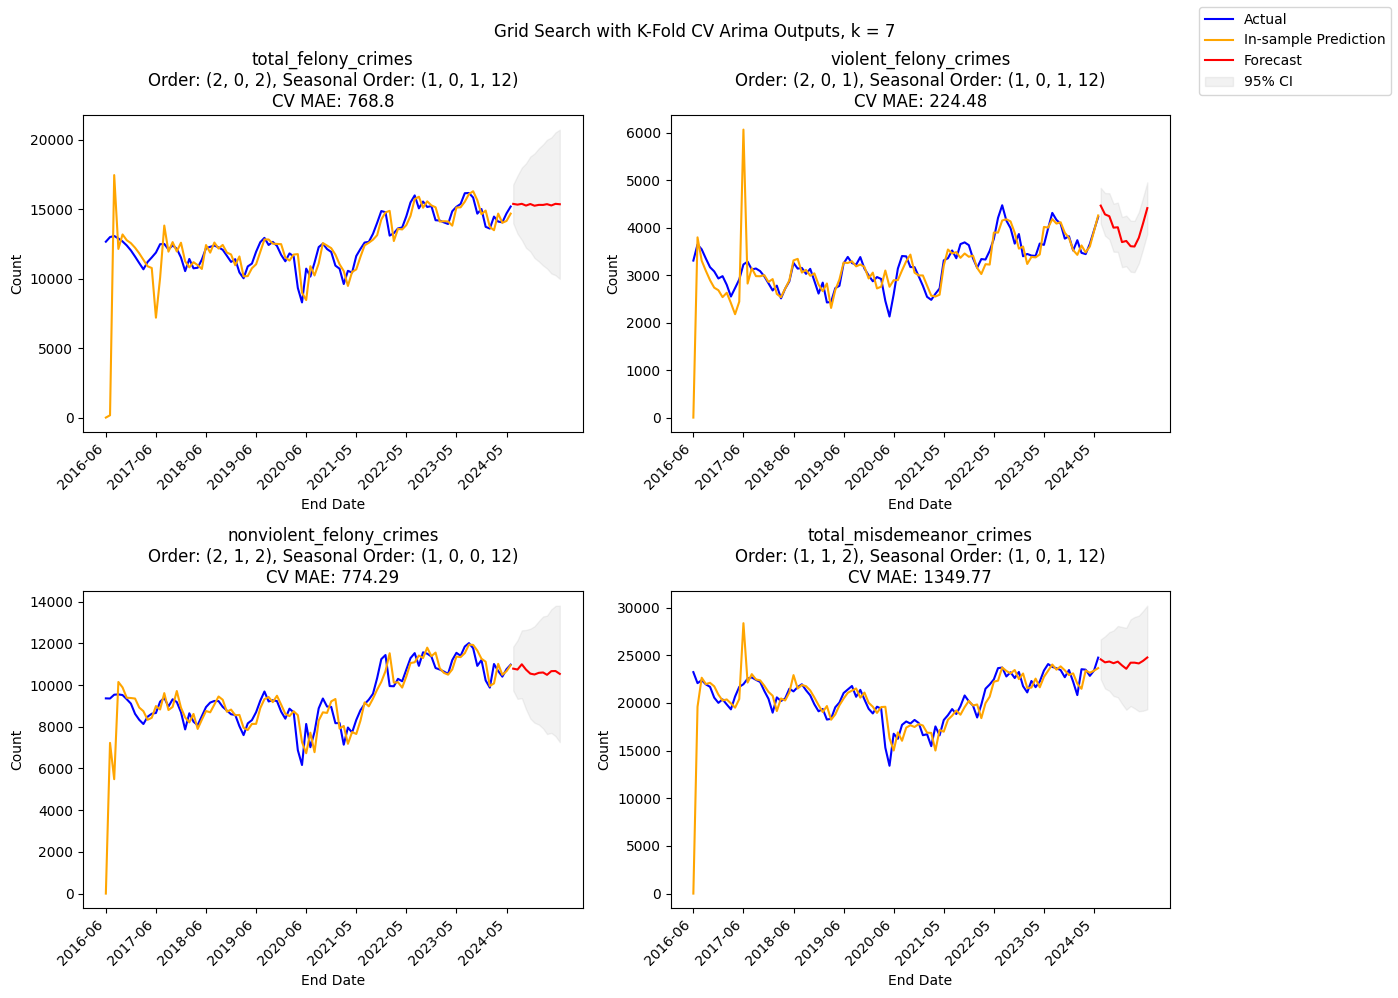

In [361]:
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each crime variable
for i, var in enumerate(crime_vars):
    ax = axes[i]
    data = joined_df[[var, 'End Date']].dropna()

    order = result_dict[var]['model params'][0]
    seasonal_order = result_dict[var]['model params'][1]
    cv_mae = result_dict[var]['mae']
    # Fit SARIMAX model
    model = SARIMAX(data[var], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    # Generate in-sample predictions
    y_pred = model_fit.fittedvalues
    # Generate out-of-sample forecast_exog
    forecast = model_fit.get_forecast(steps=12)
    y_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Plot the actual data
    ax.plot(data['End Date'], data[var], label='Actual', color='blue')

    # Plot the in-sample prediction
    ax.plot(data['End Date'], y_pred, label='In-sample Prediction', color='orange')

    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1], periods=12, freq='M')
    ax.plot(future_dates, y_forecast, label='Forecast', color='red')

    # Plot the confidence intervals
    ax.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.1, label='95% CI')
    
    # Set title and labels, including model parameters
    title = f"{var}\nOrder: {order}, Seasonal Order: {seasonal_order}\nCV MAE: {round(cv_mae,2)}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')

    # Set x-ticks and rotate labels
    ax.set_xticks(data['End Date'][::12])
    ax.set_xticklabels(data['End Date'][::12].dt.strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Grid Search with K-Fold CV Arima Outputs, k = 7")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.savefig("../Outputs/grid_search_kfold_cv_arrest_predictions.png", bbox_inches = 'tight')
plt.show()

Let's plot the residual diagnostics for each of these models

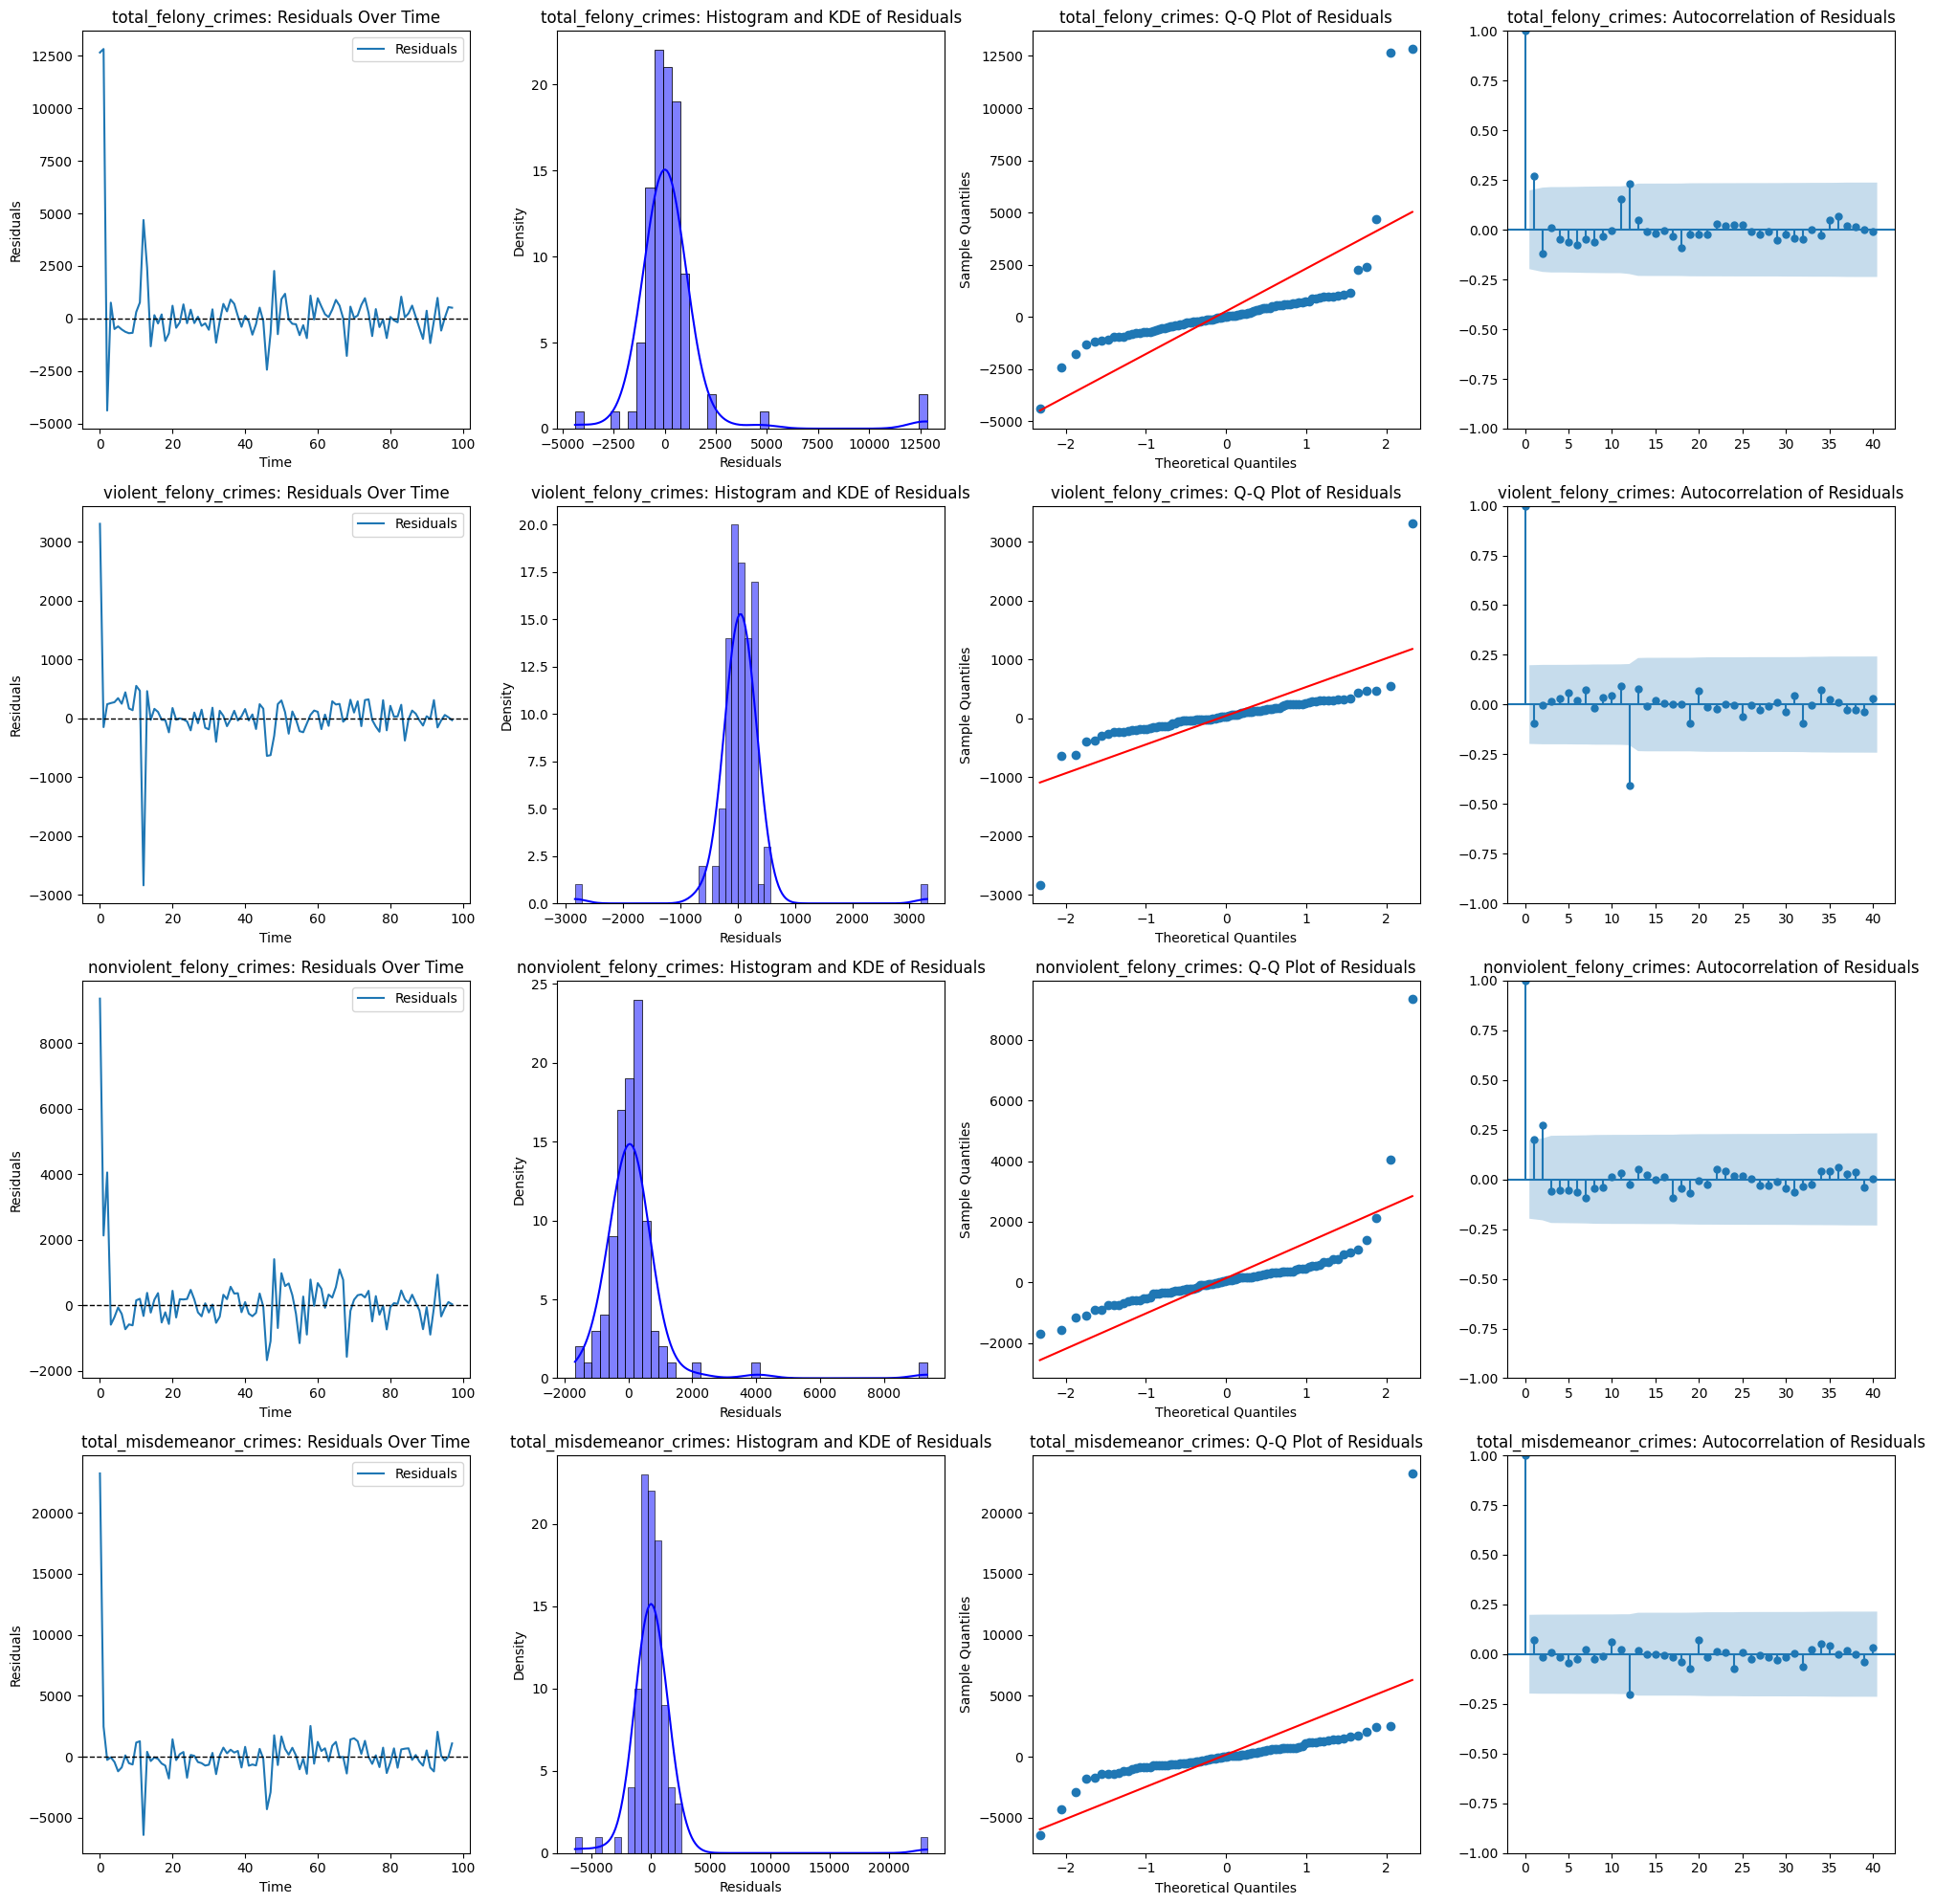

In [362]:
# Create a figure for the residual diagnostics of all variables
fig, axs = plt.subplots(len(crime_vars), 4, figsize=(20, 5 * len(crime_vars)))

# Plot each crime variable
for i, var in enumerate(crime_vars):
    ax = axes[i]
    data = joined_df[[var, 'End Date']].dropna()

    order = result_dict[var]['model params'][0]
    seasonal_order = result_dict[var]['model params'][1]
    cv_mae = result_dict[var]['mae']
    # Fit SARIMAX model
    model = SARIMAX(data[var], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    
    # Calculate residuals
    residuals = results.resid
    
    # Residuals over time
    axs[i, 0].plot(y.index, residuals, label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{var}: Residuals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals, kde=True, ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{var}: Histogram and KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals, line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{var}: Q-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[i, 3])
    axs[i, 3].set_title(f'{var}: Autocorrelation of Residuals')
    
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


Based on the outputs above, and the mean absolute error of the grid search and K-fold cross validation (with k = 7) I am inclined to pick the second method (grid search) over the auto arima method. That being said, there is something to be said about limit the number of coefficients in an ARIMA model, especially when they are for the autoregressive and moving average components. Below find a table that summarized the 8 models for the 4 variabels.


|Variable|Method|Coefficients|CV MAE|
|--------|------|------------|------|
|total_felony_crimes|auto arima|order=(0, 1, 0), seasonal_order=(2, 0, 0, 12)|869.37|
|total_felony_crimes|grid search|order=(1, 1, 1), seasonal_order=(1, 0, 0, 12)|815.31|
|violent_felony_crimes|auto arima|order=(1, 0, 0), seasonal_order=(1, 0, 1, 12)|285.95|
|violent_felony_crimes|grid search|order=(1, 0, 0), seasonal_order=(1, 0, 1, 12)|208.67|
|nonviolent_felony_crimes|auto arima|order=(2, 1, 2), seasonal_order=(1, 0, 1, 12)|nan|
|nonviolent_felony_crimes|grid search|order=(2, 1, 2), seasonal_order=(1, 0, 0, 12)|680.22|
|total_misdemeanor_crimes|auto arima|order=(0, 1, 0), seasonal_order=(0, 0, 0, 12)|1241.17|
|total_misdemeanor_crimes|grid search|order=(0, 1, 0), seasonal_order=(1, 0, 1, 12)|1080.9|

Now that we have chosen the optimal model for the crime variables, we will use them to help us predict the associated arrest metrics.


# Predicting 30-day arrests

In [363]:
def time_series_cv(y, exog, order, seasonal_order, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae_scores = []

    for train_index, test_index in tscv.split(y):
        train_y, test_y = y[train_index], y[test_index]
        if exog is not None:
            if exog.shape[0] > 1:
                train_exog, test_exog = exog.iloc[train_index], exog.iloc[test_index]
            else:
                train_exog, test_exog = exog[train_index], exog[test_index]
        else:
            train_exog, test_exog = None, None
        
        model = SARIMAX(train_y, exog=train_exog, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        predictions = results.predict(start=test_index[0], end=test_index[-1], exog=test_exog)
        mae = mean_absolute_error(test_y, predictions)
        mae_scores.append(mae)
        
    return results, np.mean(mae_scores)

def grid_search_sarimax(y, exog, p_values, q_values, P_values, Q_values, s, n_splits):
    best_score, best_params, best_result = float("inf"), None, None
    
    d_value = ndiffs(y.dropna(), test='adf')
    D_value = nsdiffs(y.dropna(), m=s)
    pdq = list(itertools.product(p_values, [d_value], q_values))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P_values, [D_value], Q_values))]
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                results, mae_score = time_series_cv(y, exog, order=param, seasonal_order=param_seasonal, n_splits=n_splits)
                if mae_score < best_score:
                    best_score, best_params = mae_score, (param, param_seasonal)
                    best_result = results
            except:
                continue
    print(best_result.summary())
    return best_params, best_score

In [364]:
# Define the arrest variables and their corresponding exogenous crime variables
arrest_vars = {
    'total_felony_arrest': 'total_felony_crimes',
    'violent_felony_arrest': 'violent_felony_crimes',
    'nonviolent_felony_arrest': 'nonviolent_felony_crimes',
    'total_misdemeanor_arrest': 'total_misdemeanor_crimes'
}
# Find and evaluate SARIMA models for each arrest variable with exogenous crime variables
arrest_models = {}

for arrest_var, exog_var in arrest_vars.items():
    y = joined_df[arrest_var].dropna()
    exog = joined_df[exog_var].dropna()
    
    # Ensure the exog variable has the same index as the target variable
    exog = exog.loc[y.index]
    
    best_params, best_score = grid_search_sarimax(y, exog, p_values, q_values, P_values, Q_values, s, n_splits=7)
    
    arrest_models[arrest_var] = {'model params': best_params, 'mae': best_score}
    print(f"Best model for {arrest_var}: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")


                                SARIMAX Results                                
Dep. Variable:     total_felony_arrest   No. Observations:                   86
Model:                SARIMAX(2, 1, 0)   Log Likelihood                -663.993
Date:                 Wed, 14 Aug 2024   AIC                           1335.985
Time:                         19:17:54   BIC                           1345.756
Sample:                              0   HQIC                          1339.915
                                  - 86                                         
Covariance Type:                   opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
total_felony_crimes     0.3248      0.081      4.029      0.000       0.167       0.483
ar.L1                  -0.3970      0.087     -4.560      0.000      -0.568      -0.226
ar.L2   

In [365]:
# Define the function to get future exogenous values
def get_future_exog(var, steps=12):
    model_params = result_dict[var]['model params']
    order, seasonal_order = model_params
    
    y = joined_df[var].dropna()
    
    # Fit the model to the entire data
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    
    # Forecast future values
    future_exog = results.get_forecast(steps=steps).predicted_mean
    return future_exog

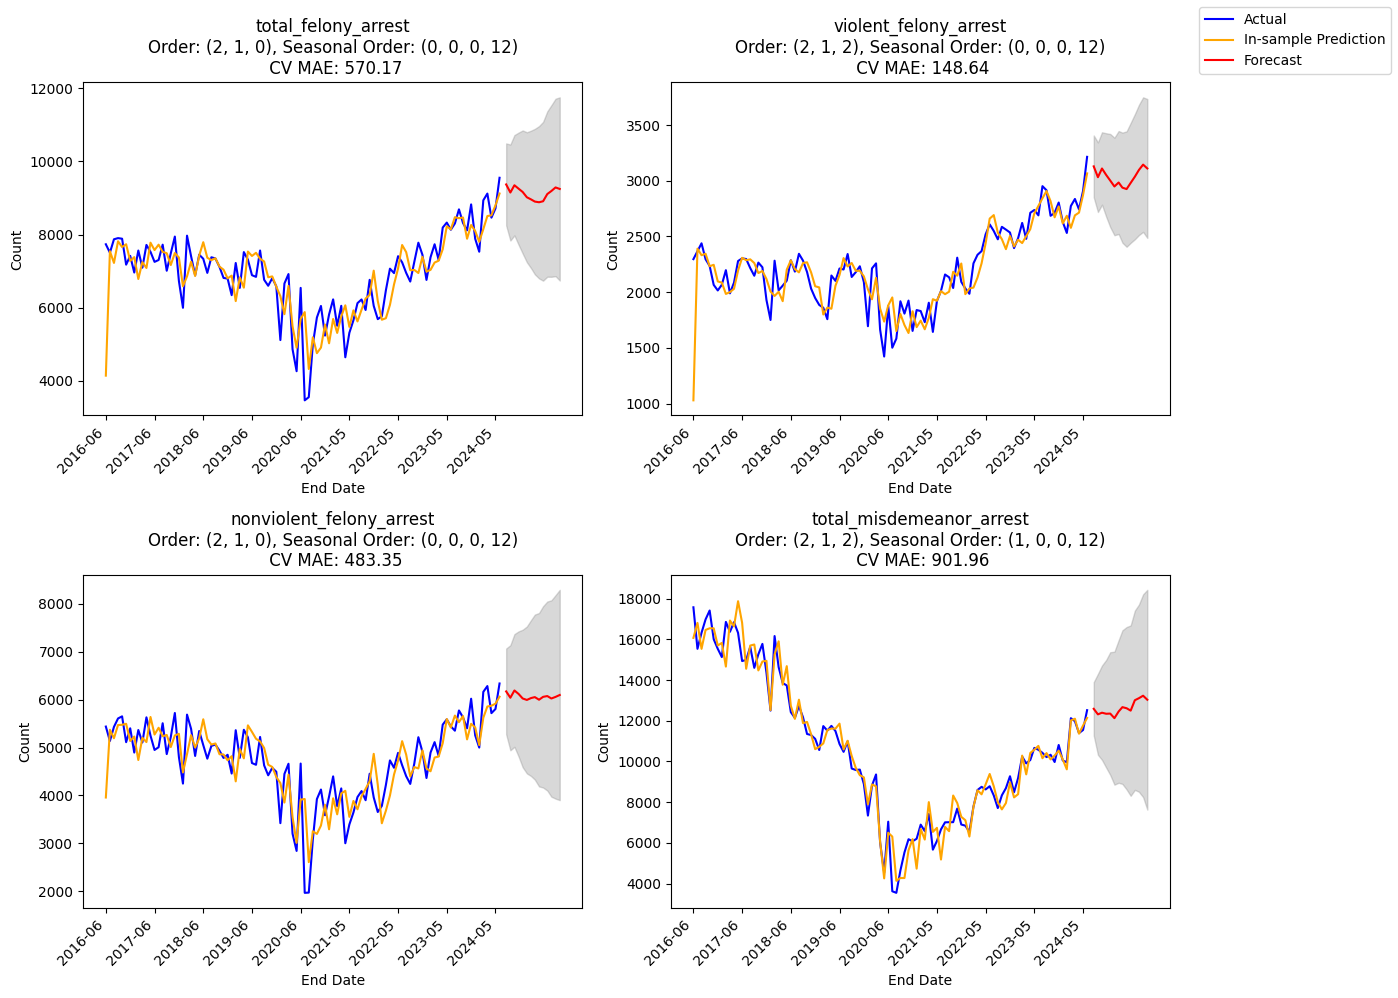

In [366]:
# Define the arrest variables and their corresponding crime variables
arrest_vars = ['total_felony_arrest', 'violent_felony_arrest', 'nonviolent_felony_arrest', 'total_misdemeanor_arrest']
crime_vars = ['total_felony_crimes', 'violent_felony_crimes', 'nonviolent_felony_crimes', 'total_misdemeanor_crimes']
pred_steps = 12 + (len(joined_df['ADP'].dropna()) - len(joined_df['total_felony_crimes'].dropna()))
# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (arrest_var, crime_var) in enumerate(zip(arrest_vars, crime_vars)):
    ax = axes[i]
    data = joined_df[[arrest_var, 'End Date']].dropna()
    y = data[arrest_var].dropna()
    exog = joined_df[crime_var].dropna()

    
    # Ensure the exog variable has the same index as the target variable
    exog = exog.loc[y.index]
    
    # Extract the best model parameters
    best_params = arrest_models[arrest_var]['model params']
    order, seasonal_order = best_params
    mae = arrest_models[arrest_var]['mae']
    
    # Fit the model to the entire dataset
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    
    # In-sample prediction
    in_sample_pred = results.predict(start=0, end=len(y)-1, exog=exog)
    
    # Forecast for the next 12 steps
    future_exog = get_future_exog(crime_var, steps=pred_steps)
    forecast = results.get_forecast(steps=pred_steps, exog=future_exog)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Plot the actual data
    ax.plot(data['End Date'], y, label='Actual', color='blue')
    
    # Plot the in-sample prediction
    ax.plot(data['End Date'], in_sample_pred, label='In-sample Prediction', color='orange')
    
    # Plot the forecast
    future_dates = pd.date_range(start=data['End Date'].iloc[-1] + pd.Timedelta(days=30), periods=pred_steps, freq='M')
    ax.plot(future_dates, forecast_mean, label='Forecast', color='red')
    
    # Plot the confidence intervals
    ax.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.3)
    
    # Set title and labels, including model parameters and MAE
    title = f"{arrest_var}\nOrder: {order}, Seasonal Order: {seasonal_order}\n CV MAE: {mae:.2f}"
    ax.set_title(title)
    ax.set_xlabel('End Date')
    ax.set_ylabel('Count')
    
    # Set x-ticks and rotate labels
    ax.set_xticks(joined_df['End Date'][::12])
    ax.set_xticklabels(joined_df['End Date'][::12].dt.strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.show()


Lets plot the residuals

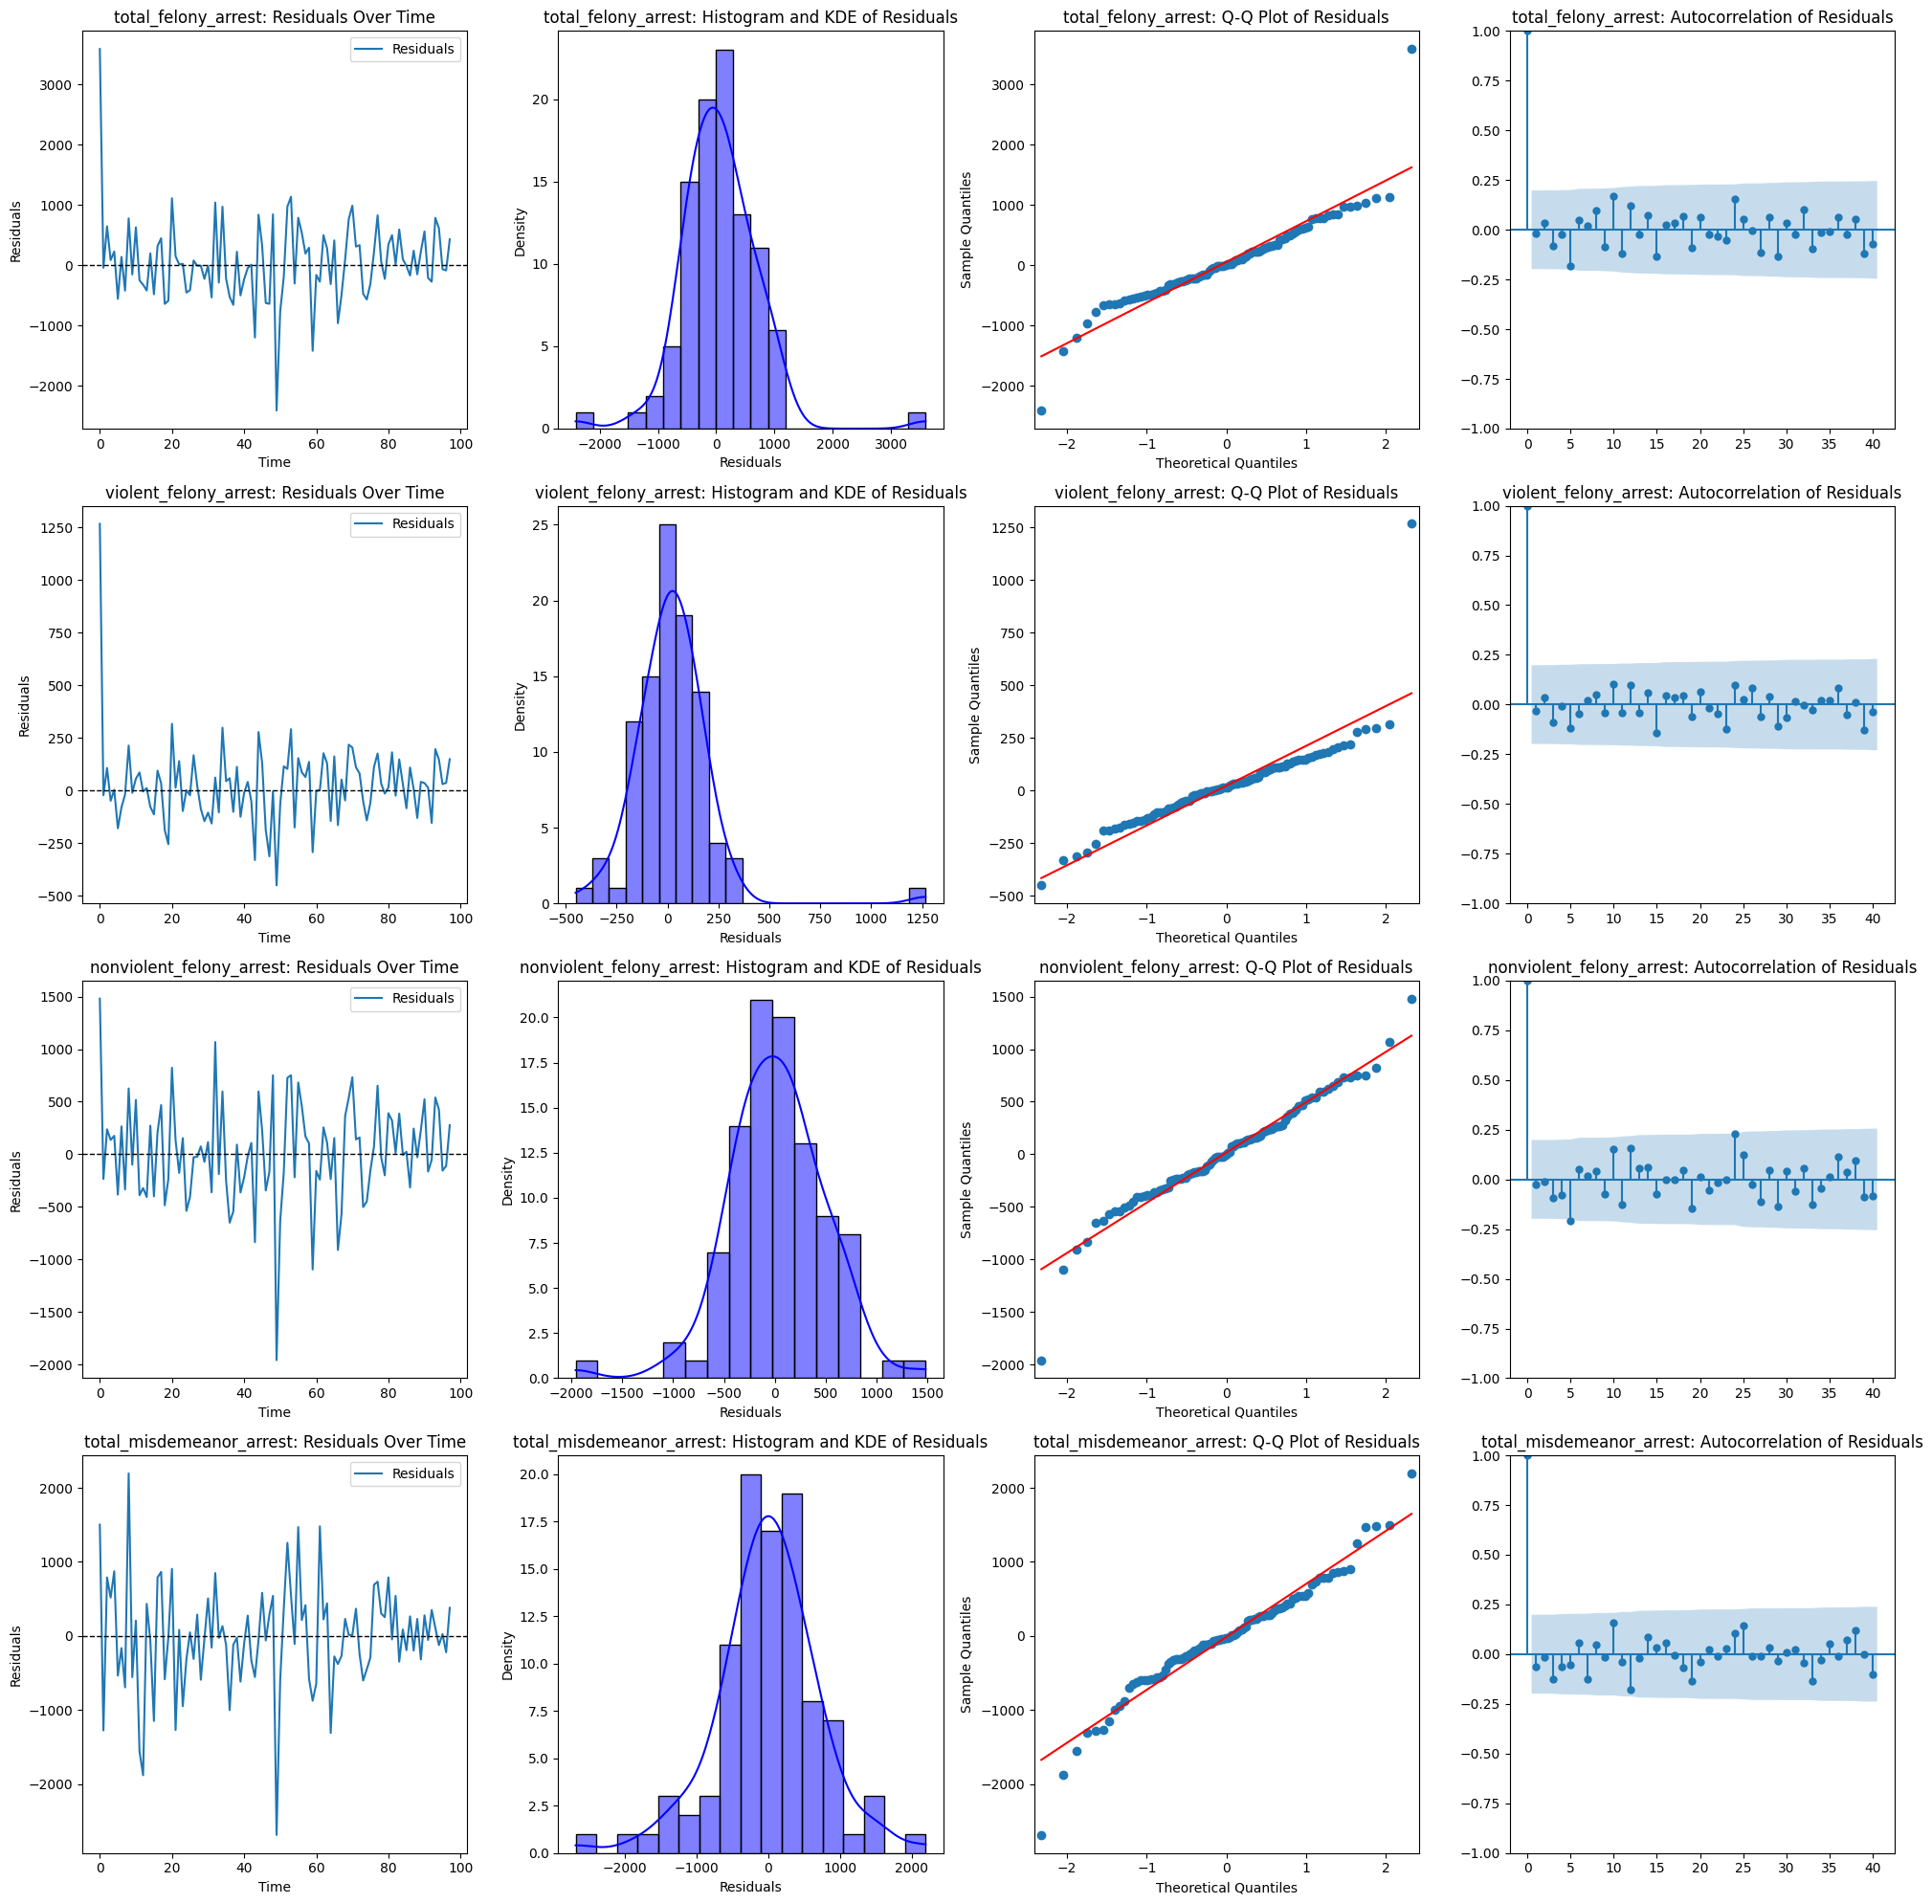

In [367]:
# Create a figure for the residual diagnostics of all variables
fig, axs = plt.subplots(len(crime_vars), 4, figsize=(20, 5 * len(crime_vars)))

for i, (arrest_var, crime_var) in enumerate(zip(arrest_vars, crime_vars)):
    ax = axes[i]
    data = joined_df[[arrest_var, 'End Date']].dropna()
    y = data[arrest_var].dropna()
    exog = joined_df[crime_var].dropna()

    
    # Ensure the exog variable has the same index as the target variable
    exog = exog.loc[y.index]
    
    # Extract the best model parameters
    best_params = arrest_models[arrest_var]['model params']
    order, seasonal_order = best_params
    mae = arrest_models[arrest_var]['mae']
    
    # Fit the model to the entire dataset
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    
    # Calculate residuals
    residuals = results.resid
    
    # Residuals over time
    axs[i, 0].plot(y.index, residuals, label='Residuals')
    axs[i, 0].axhline(0, linestyle='--', color='black', linewidth=1)
    axs[i, 0].set_title(f'{arrest_var}: Residuals Over Time')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Residuals')
    axs[i, 0].legend()
    
    # Histogram and KDE plot of residuals
    sns.histplot(residuals, kde=True, ax=axs[i, 1], color='blue')
    axs[i, 1].set_title(f'{arrest_var}: Histogram and KDE of Residuals')
    axs[i, 1].set_xlabel('Residuals')
    axs[i, 1].set_ylabel('Density')
    
    # Q-Q plot of residuals
    sm.qqplot(residuals, line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'{arrest_var}: Q-Q Plot of Residuals')
    
    # ACF plot of residuals
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[i, 3])
    axs[i, 3].set_title(f'{arrest_var}: Autocorrelation of Residuals')
    
# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()


# Predicting 30-day admission counts

Now that we have established models for arrest metrics, we will try and fit the optimal model for predicting DOC admission counts. We have 4 exogenous variables and two potential models that we can test that ensure our variables are mutually exclusive and independent. 

Model 1 Exogenous Variables: Total Felony Arrests & Total Misdemeanor Arrests

Model 2 Exogenous Variables: Violent Felony Arrests, Non-violent felony arrests, and misdemeanor arrests.

We will decide which model is best using a grid search & k-fold cross validation method as used for prior models. However, we should ultimately decide which model to use based on the model's summary output and statistical significance. 

In [368]:
print(len(joined_df['admission_count'].dropna()))

99


In [369]:
print(len(joined_df['total_felony_arrest'].dropna()))

98


Note that the lengths of our data differ. We predicted 12 future timestamps for crime and arrests because we are ultimately trying to predict next year's jail population. However, we will need to predict 12 plus the difference between these data arrays to account for any missing data.

In [370]:
crime_arr_pred_n = 12 + (len(joined_df['ADP'].dropna()) - len(joined_df['total_felony_arrest'].dropna()))
print(crime_arr_pred_n)

14


In [371]:
#redo predictions for arrests so we can use in the training of the doc admission model
exog_pred_dict = {}

for i, (arrest_var, crime_var) in enumerate(zip(arrest_vars, crime_vars)):
    data = joined_df[[arrest_var, 'End Date']].dropna()
    y = data[arrest_var].dropna()
    exog = joined_df[crime_var].dropna()
    
    # Ensure the exog variable has the same index as the target variable
    exog = exog.loc[y.index]
    
    # Extract the best model parameters
    best_params = arrest_models[arrest_var]['model params']
    order, seasonal_order = best_params
    
    # Fit the model to the entire dataset
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    
    # In-sample prediction
    in_sample_pred = results.predict(start=0, end=len(y)-1, exog=exog)
    
    # Forecast for the next 12 steps
    future_exog = get_future_exog(crime_var, steps=crime_arr_pred_n)
    forecast = results.get_forecast(steps=crime_arr_pred_n, exog=future_exog)
    forecast_mean = forecast.predicted_mean
    #store results
    exog_pred_dict[arrest_var] = forecast_mean.values

In [372]:
exog_pred_dict

{'total_felony_arrest': array([9368.70602392, 9147.98211303, 9346.63094066, 9252.27943623,
        9162.73229904, 9018.50440601, 8959.42304042, 8900.22738932,
        8882.16062687, 8909.07311314, 9106.29607581, 9188.80577271,
        9286.67183334, 9245.57113985]),
 'violent_felony_arrest': array([3128.57253392, 3031.37532578, 3109.47011158, 3051.44706104,
        3001.17496789, 2948.14282694, 2983.67770351, 2937.52590484,
        2924.89201757, 2980.06119305, 3035.93643182, 3096.25432018,
        3144.27951457, 3109.88864525]),
 'nonviolent_felony_arrest': array([6171.54470038, 6039.72505983, 6191.24563169, 6118.20894093,
        6024.10371205, 5993.84839906, 6033.01644637, 6052.64382097,
        5998.25774756, 6058.15396094, 6074.65800401, 6023.88306022,
        6056.93348687, 6096.96668985]),
 'total_misdemeanor_arrest': array([12582.6542989 , 12311.2668868 , 12391.99550594, 12340.55818697,
        12349.07011102, 12123.62999412, 12450.08751162, 12665.23045032,
        12611.280939

In [373]:
adm_models = {'admission_count': {'model 1': ['total_felony_arrest','total_misdemeanor_arrest'],
                        'model 2': ['violent_felony_arrest', 'nonviolent_felony_arrest', 'total_misdemeanor_arrest'],
                        'model 3': ['violent_felony_arrest', 'total_misdemeanor_arrest'],
                        'model 4': None}
                        }

for target_val, model in adm_models.items():
    print(target_val,model)
    for model_nm, vars in model.items():
        print(vars)

admission_count {'model 1': ['total_felony_arrest', 'total_misdemeanor_arrest'], 'model 2': ['violent_felony_arrest', 'nonviolent_felony_arrest', 'total_misdemeanor_arrest'], 'model 3': ['violent_felony_arrest', 'total_misdemeanor_arrest'], 'model 4': None}
['total_felony_arrest', 'total_misdemeanor_arrest']
['violent_felony_arrest', 'nonviolent_felony_arrest', 'total_misdemeanor_arrest']
['violent_felony_arrest', 'total_misdemeanor_arrest']
None


In [374]:
diff_n = (len(joined_df['admission_count'].dropna()) - len(joined_df['total_felony_arrest'].dropna()))
# Find and evaluate SARIMA models for each arrest variable with exogenous crime variables
adm_model_results = {}
y = joined_df['admission_count'].dropna()

for target_val, model in adm_models.items():
    for model_nm, vars in model.items():
        print('Training model with exogenous variables: ', vars)
        if vars is not None:
            exog = joined_df[vars].dropna()
            #append the predicted values to make the length of y and exog the same
            missing_data = pd.DataFrame(columns = exog.columns)
            for var in exog.columns.to_list():
                missing_data[var] = exog_pred_dict[var][0:diff_n]
            exog = pd.concat([exog,missing_data], ignore_index=True)       
            # Ensure the exog variable has the same index as the target variable
            exog = exog.loc[y.index]
        else:
            exog = None
        
        best_params, best_score = grid_search_sarimax(y, exog, p_values, q_values, P_values, Q_values, s, n_splits=7)
        
        adm_model_results[model_nm] = {'model params': best_params, 'mae': best_score}
        print(f"Best model for {target_val} with {vars} exogenous variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")


Training model with exogenous variables:  ['total_felony_arrest', 'total_misdemeanor_arrest']
                                      SARIMAX Results                                       
Dep. Variable:                      admission_count   No. Observations:                   87
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood                -560.429
Date:                              Wed, 14 Aug 2024   AIC                           1132.857
Time:                                      19:23:21   BIC                           1147.583
Sample:                                           0   HQIC                          1138.784
                                               - 87                                         
Covariance Type:                                opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [375]:
adm_model_results

{'model 1': {'model params': ((0, 1, 2), (0, 0, 1, 12)),
  'mae': 244.3579624273562},
 'model 2': {'model params': ((1, 1, 2), (1, 0, 0, 12)),
  'mae': 232.85680482848193},
 'model 3': {'model params': ((0, 1, 2), (1, 0, 0, 12)),
  'mae': 218.53211099676795},
 'model 4': {'model params': ((2, 1, 1), (0, 0, 0, 12)),
  'mae': 464.88753877678477}}

Based on the results above, I am inclined to select the model with the 3 seperate types of arrests (violent, non-violent, and misdemeanor) even if non-violent arrests don't seem to be statistically significant in measuring admission counts.

In [376]:
diff_n

1

In [377]:
exog_pred_dict

{'total_felony_arrest': array([9368.70602392, 9147.98211303, 9346.63094066, 9252.27943623,
        9162.73229904, 9018.50440601, 8959.42304042, 8900.22738932,
        8882.16062687, 8909.07311314, 9106.29607581, 9188.80577271,
        9286.67183334, 9245.57113985]),
 'violent_felony_arrest': array([3128.57253392, 3031.37532578, 3109.47011158, 3051.44706104,
        3001.17496789, 2948.14282694, 2983.67770351, 2937.52590484,
        2924.89201757, 2980.06119305, 3035.93643182, 3096.25432018,
        3144.27951457, 3109.88864525]),
 'nonviolent_felony_arrest': array([6171.54470038, 6039.72505983, 6191.24563169, 6118.20894093,
        6024.10371205, 5993.84839906, 6033.01644637, 6052.64382097,
        5998.25774756, 6058.15396094, 6074.65800401, 6023.88306022,
        6056.93348687, 6096.96668985]),
 'total_misdemeanor_arrest': array([12582.6542989 , 12311.2668868 , 12391.99550594, 12340.55818697,
        12349.07011102, 12123.62999412, 12450.08751162, 12665.23045032,
        12611.280939

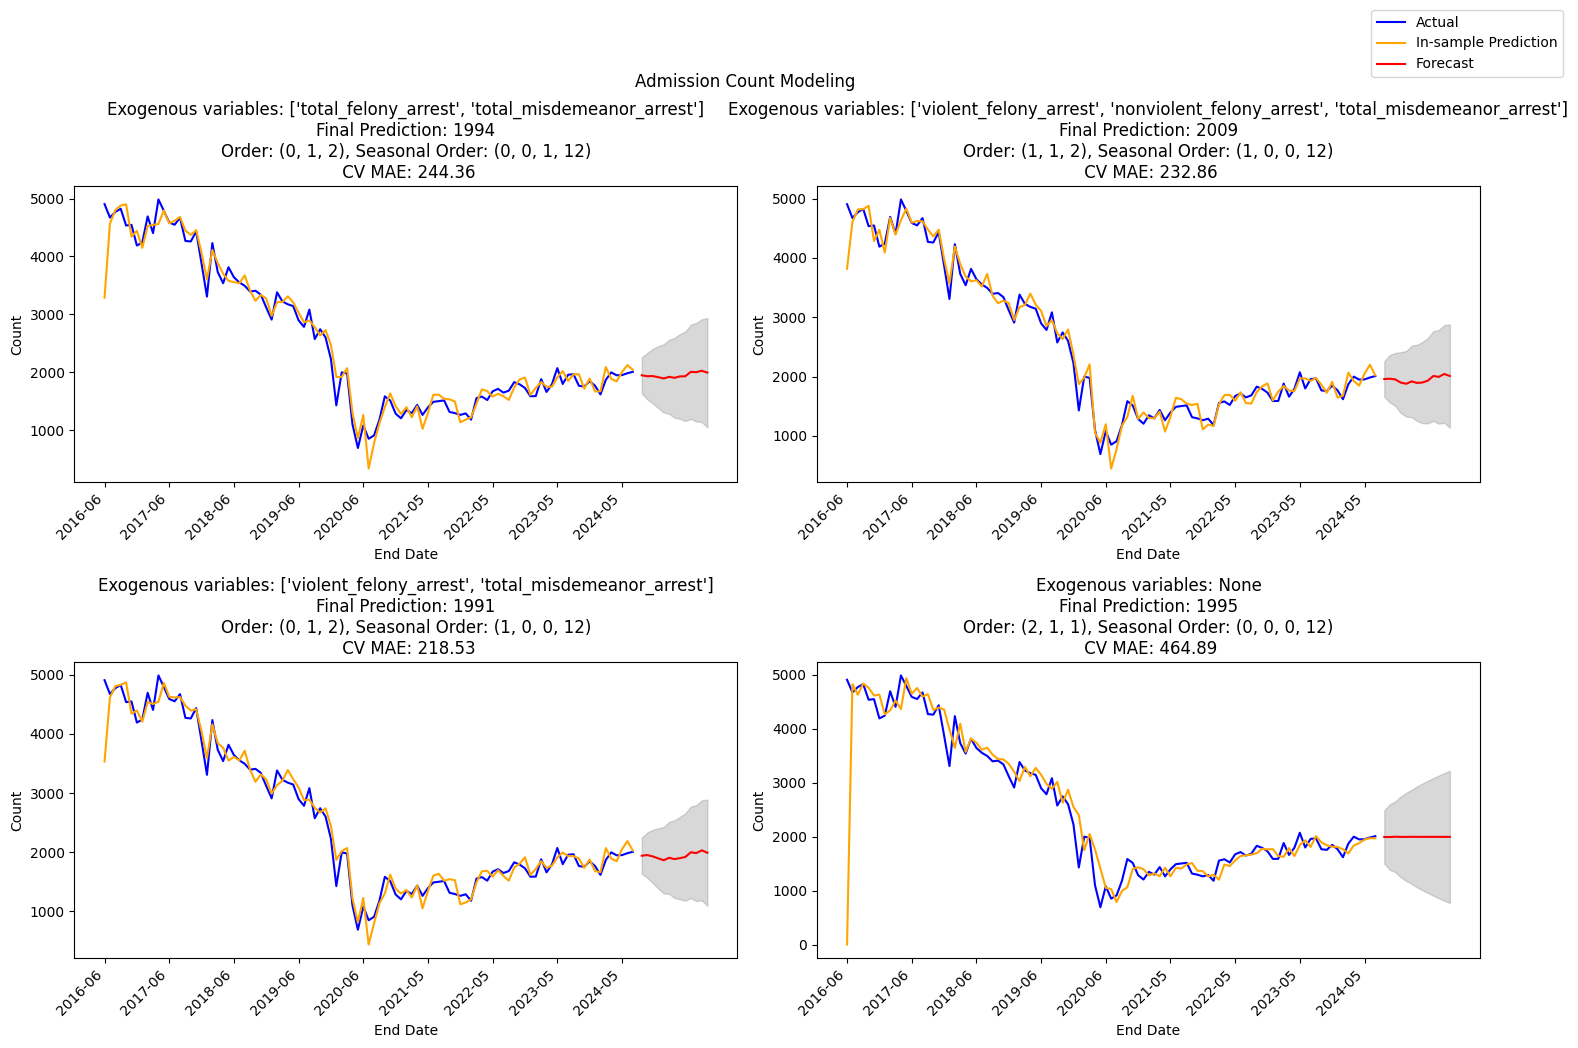

In [378]:
exog_diff_n = (len(joined_df['admission_count'].dropna()) - len(joined_df['total_felony_arrest'].dropna()))
forecast_diff_n = (len(joined_df['ADP'].dropna()) - len(joined_df['admission_count'].dropna()))
# Set up the subplots
fig, axes = plt.subplots(2,2, figsize=(15, 10))
axes = axes.flatten()

# for i, (arrest_var, crime_var) in enumerate(zip(arrest_vars, crime_vars)):
for target_val, model in adm_models.items():
    data = joined_df[[target_val, 'End Date']].dropna()
    y = data[target_val].dropna()

    for i, (model_nm, vars) in enumerate(model.items()):
        if vars is not None:
            exog = joined_df[vars].dropna()
            #append the predicted values to make the length of y and exog the same
            missing_data = pd.DataFrame(columns = exog.columns)
            for var in exog.columns.to_list():
                missing_data[var] = exog_pred_dict[var][0:exog_diff_n]
            exog = pd.concat([exog,missing_data], ignore_index=True)       
            # Ensure the exog variable has the same index as the target variable
            exog = exog.loc[y.index]
            # Forecast for the next 12 steps
            future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+12+forecast_diff_n))
            for var in exog.columns.to_list():
                future_exog[var] = exog_pred_dict[var][exog_diff_n:]
        else:
            exog = None
            future_exog = None
    
        ax = axes[i]

    
        # Extract the best model parameters
        best_params = adm_model_results[model_nm]['model params']
        order, seasonal_order = best_params
        mae = adm_model_results[model_nm]['mae']
        
        # Fit the model to the entire dataset
        model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
    
        # In-sample prediction
        in_sample_pred = results.predict(start=0, end=len(y)-1, exog=exog)
        
        forecast = results.get_forecast(steps=12+forecast_diff_n, exog=future_exog)
        forecast_mean = forecast.predicted_mean
        adm_model_results[model_nm]['prediction'] = forecast_mean.values
        conf_int = forecast.conf_int()
        
        # Plot the actual data
        ax.plot(data['End Date'], y, label='Actual', color='blue')
        
        # Plot the in-sample prediction
        ax.plot(data['End Date'], in_sample_pred, label='In-sample Prediction', color='orange')
        
        # Plot the forecast
        future_dates = pd.date_range(start=data['End Date'].iloc[-1] + pd.Timedelta(days=30), periods=12+forecast_diff_n, freq='M')
        ax.plot(future_dates, forecast_mean, label='Forecast', color='red')
        
        # Plot the confidence intervals
        ax.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.3)
        
        # Set title and labels, including model parameters and MAE
        title = f"Exogenous variables: {vars}\nFinal Prediction: {round(forecast_mean.iloc[-1])}\nOrder: {order}, Seasonal Order: {seasonal_order}\n CV MAE: {mae:.2f}"
        ax.set_title(title)
        ax.set_xlabel('End Date')
        ax.set_ylabel('Count')
        
        # Set x-ticks and rotate labels
        ax.set_xticks(joined_df['End Date'][::12])
        ax.set_xticklabels(joined_df['End Date'][::12].dt.strftime('%Y-%m'), rotation=45, ha='right')

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1.05))
fig.suptitle("Admission Count Modeling")
# Adjust layout
plt.tight_layout()  # Leave space on the right for the legend
plt.show()


['violent_felony_arrest', 'nonviolent_felony_arrest', 'total_misdemeanor_arrest']


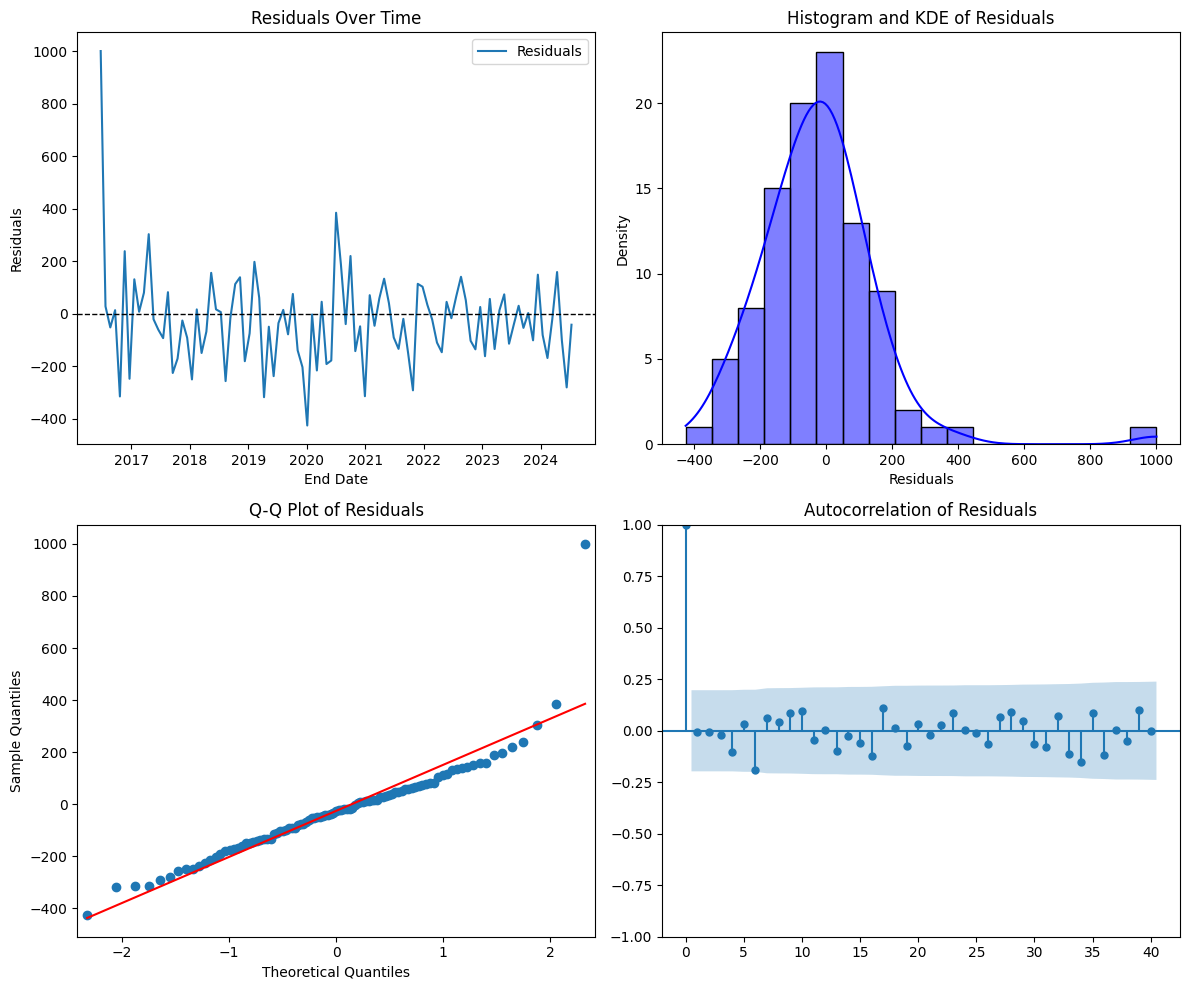

In [379]:
#plot the residual plots for the second model
target_val = 'admission_count'
vars = adm_models[target_val]['model 2']

print(vars)
data = joined_df[[target_val, 'End Date']].dropna()
y = data[target_val].dropna()
exog = joined_df[vars].dropna()
#append the predicted values to make the length of y and exog the same
missing_data = pd.DataFrame(columns = exog.columns)
for var in exog.columns.to_list():
    missing_data[var] = exog_pred_dict[var][0:exog_diff_n]
exog = pd.concat([exog,missing_data], ignore_index=True)       
# Ensure the exog variable has the same index as the target variable
exog = exog.loc[y.index]
# Forecast for the next 12 steps
future_exog = pd.DataFrame(columns = exog.columns, index = np.arange(len(exog),len(exog)+12+forecast_diff_n))
for var in exog.columns.to_list():
    future_exog[var] = exog_pred_dict[var][exog_diff_n:]

# Extract the best model parameters
best_params = adm_model_results[model_nm]['model params']
order, seasonal_order = best_params
mae = adm_model_results[model_nm]['mae']

# Fit the model to the entire dataset
model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

# Calculate residuals
residuals = results.resid

# Set up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Residuals over time
axs[0, 0].plot(data['End Date'], residuals, label='Residuals')
axs[0, 0].axhline(0, linestyle='--', color='black', linewidth=1)
axs[0, 0].set_title('Residuals Over Time')
axs[0, 0].set_xlabel('End Date')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].legend()

# Histogram and KDE plot of residuals
sns.histplot(residuals, kde=True, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('Histogram and KDE of Residuals')
axs[0, 1].set_xlabel('Residuals')
axs[0, 1].set_ylabel('Density')

# Q-Q plot of residuals
sm.qqplot(residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of Residuals')

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[1, 1])
axs[1, 1].set_title('Autocorrelation of Residuals')

# Adjust layout
plt.tight_layout()
plt.show()

# Step 3: Predicting Average Daily Jail Population

We will use the admission count variable in addition to various policy intervention event binary variables to predict the 30-day average daily jail population. 

In [380]:
# define key dates
#create event flag based on the daily pop index, then we will redefine for week and month
# Define key event dates
covid_start_date = pd.to_datetime('2020-03-12')
covid_end_date = pd.to_datetime('2021-06-25')
less_is_more_date = pd.to_datetime('2022-03-01')
bail_reform_date = pd.to_datetime('2019-12-01')
raise_the_age_17_date = pd.to_datetime('2018-10-01')
raise_the_age_18_date = pd.to_datetime('2019-10-01')
de_blasio_admin = pd.to_datetime('2014-01-01')
adams_admin = pd.to_datetime('2022-01-01')

#import the daily ts signal
daily_pop = pd.read_csv("../Data/daily_pop.csv", index_col=0)
# Convert 'snapshot_date' to datetime format
daily_pop['snapshot_date'] = pd.to_datetime(daily_pop['snapshot_date'])

# Create binary variables for key events
daily_pop['covid_event'] = ((daily_pop.snapshot_date >= covid_start_date) & (daily_pop.snapshot_date <= covid_end_date)).astype(int)
daily_pop['less_is_more_event'] = (daily_pop.snapshot_date >= less_is_more_date).astype(int)
daily_pop['bail_reform_event'] = (daily_pop.snapshot_date >= bail_reform_date).astype(int)
daily_pop['raise_the_age_17_event'] = (daily_pop.snapshot_date >= raise_the_age_17_date).astype(int)
daily_pop['raise_the_age_18_event'] = (daily_pop.snapshot_date >= raise_the_age_18_date).astype(int)
daily_pop['de_blasio_admin'] = ((daily_pop.snapshot_date >= de_blasio_admin) & (daily_pop.snapshot_date < adams_admin)).astype(int)
daily_pop['adams_admin'] = (daily_pop.snapshot_date >= adams_admin).astype(int)

# Check the dataframe with added event columns
daily_pop.head()

,snapshot_date,Total Population,covid_event,less_is_more_event,bail_reform_event,raise_the_age_17_event,raise_the_age_18_event,de_blasio_admin,adams_admin
0,2016-06-02,9836,0,0,0,0,0,1,0
1,2016-06-03,9780,0,0,0,0,0,1,0
2,2016-06-04,9765,0,0,0,0,0,1,0
3,2016-06-05,9894,0,0,0,0,0,1,0
4,2016-06-06,9904,0,0,0,0,0,1,0


In [381]:
#aggregate to 30-day periods
max_date = daily_pop['snapshot_date'].max()
monthly_pop = daily_pop.resample('30D',on='snapshot_date',origin = max_date,closed='right',label = 'right').agg({
    'Total Population': 'mean',
    'covid_event': 'max',
    'less_is_more_event': 'max',
    'bail_reform_event': 'max',
    'raise_the_age_17_event': 'max',
    'raise_the_age_18_event': 'max',
    'de_blasio_admin':'max',
    'adams_admin':'max'
}).round().fillna(0).reset_index()

# Rename the 'index' column to 'Start Date'
monthly_pop = monthly_pop.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
monthly_pop['Start Date'] = monthly_pop['End Date'] - pd.to_timedelta(29, unit='D')

monthly_pop.head()

,End Date,ADP,covid_event,less_is_more_event,bail_reform_event,raise_the_age_17_event,raise_the_age_18_event,de_blasio_admin,adams_admin,Start Date
0,2016-06-24,9806.0,0,0,0,0,0,1,0,2016-05-26
1,2016-07-24,9764.0,0,0,0,0,0,1,0,2016-06-25
2,2016-08-23,9762.0,0,0,0,0,0,1,0,2016-07-25
3,2016-09-22,9863.0,0,0,0,0,0,1,0,2016-08-24
4,2016-10-22,9815.0,0,0,0,0,0,1,0,2016-09-23


In [382]:
#merge with the joined df. only include the policy interventions
joined_df = joined_df.merge(monthly_pop.drop(columns='ADP'), how = 'left',
                            left_on=['Start Date', 'End Date'], right_on=['Start Date', 'End Date'])
joined_df.head()

,Start Date,End Date,ADP,total_felony_crimes,violent_felony_crimes,nonviolent_felony_crimes,total_misdemeanor_crimes,total_felony_arrest,violent_felony_arrest,nonviolent_felony_arrest,total_misdemeanor_arrest,admission_count,covid_event,less_is_more_event,bail_reform_event,raise_the_age_17_event,raise_the_age_18_event,de_blasio_admin,adams_admin
0,2016-05-26,2016-06-24,9806.0,12664.0,3306.0,9358.0,23232.0,7734.0,2296.0,5438.0,17571.0,4905.0,0,0,0,0,0,1,0
1,2016-06-25,2016-07-24,9764.0,12997.0,3645.0,9352.0,22075.0,7504.0,2367.0,5137.0,15530.0,4672.0,0,0,0,0,0,1,0
2,2016-07-25,2016-08-23,9762.0,13078.0,3543.0,9535.0,22391.0,7870.0,2438.0,5432.0,16319.0,4770.0,0,0,0,0,0,1,0
3,2016-08-24,2016-09-22,9863.0,12897.0,3348.0,9549.0,21945.0,7902.0,2295.0,5607.0,16978.0,4825.0,0,0,0,0,0,1,0
4,2016-09-23,2016-10-22,9815.0,12684.0,3166.0,9518.0,21691.0,7886.0,2235.0,5651.0,17413.0,4535.0,0,0,0,0,0,1,0


In [383]:
joined_df.tail()

,Start Date,End Date,ADP,total_felony_crimes,violent_felony_crimes,nonviolent_felony_crimes,total_misdemeanor_crimes,total_felony_arrest,violent_felony_arrest,nonviolent_felony_arrest,total_misdemeanor_arrest,admission_count,covid_event,less_is_more_event,bail_reform_event,raise_the_age_17_event,raise_the_age_18_event,de_blasio_admin,adams_admin
95,2024-03-15,2024-04-13,6300.0,14059.0,3659.0,10400.0,22842.0,8461.0,2743.0,5718.0,11389.0,1948.0,0,1,1,1,1,0,1
96,2024-04-14,2024-05-13,6325.0,14700.0,3943.0,10757.0,23397.0,8713.0,2908.0,5805.0,11542.0,1951.0,0,1,1,1,1,0,1
97,2024-05-14,2024-06-12,6333.0,15199.0,4224.0,10975.0,24753.0,9551.0,3214.0,6337.0,12517.0,1983.0,0,1,1,1,1,0,1
98,2024-06-13,2024-07-12,6391.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.0,0,1,1,1,1,0,1
99,2024-07-13,2024-08-11,6394.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1,1,0,1


In [384]:
len(joined_df['admission_count'].dropna())

99

First we need to optimize the parameters for ADP model

In [385]:
# Define the arrest variables and their corresponding exogenous crime variables
adp_models = {
    'model 1': 'admission_count',
    'model 2': ['admission_count', 'covid_event', 'bail_reform_event','less_is_more_event',
                'raise_the_age_17_event','raise_the_age_18_event','de_blasio_admin', 'adams_admin'],
    'model 3': ['admission_count', 'covid_event', 'bail_reform_event','less_is_more_event'],
    'model 4': ['admission_count', 'covid_event'],
    'model 5': ['admission_count', 'bail_reform_event'],
    'model 6': None
}
# Find and evaluate SARIMA models for each arrest variable with exogenous crime variables
adp_models_results = {}

In [386]:
y = joined_df['ADP'].dropna()
#add the first predicted value of admission count from model 2 to the joined_df so there are no dim issues
joined_df.at[len(joined_df['admission_count'].dropna()),'admission_count'] = adm_model_results['model 2']['prediction'][0].round()
for model, exog_var in adp_models.items():
    if exog_var is not None:
        exog = joined_df[exog_var].dropna()
        exog = exog.loc[y.index]  # Ensure the exog variable has the same index as the target variable
    else:
        exog = None
    
    best_params, best_score = grid_search_sarimax(y, exog, p_values, q_values, P_values, Q_values, s, n_splits=7)
    
    adp_models_results[model] = {'model params': best_params, 'mae': best_score}
    print(f"Best model with {exog_var} as exogenous variables: Order {best_params[0]}, Seasonal Order {best_params[1]}, MAE: {best_score}")

                                      SARIMAX Results                                       
Dep. Variable:                                  ADP   No. Observations:                   88
Model:             SARIMAX(0, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -578.627
Date:                              Wed, 14 Aug 2024   AIC                           1165.253
Time:                                      19:29:15   BIC                           1175.070
Sample:                                           0   HQIC                          1169.204
                                               - 88                                         
Covariance Type:                                opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.1816      0.049      3.719      0.000       0.086       0.277
ar.S

In [387]:
adp_models_results

{'model 1': {'model params': ((0, 2, 0), (1, 0, 1, 12)),
  'mae': 364.3155170736254},
 'model 2': {'model params': ((0, 2, 0), (1, 0, 1, 12)),
  'mae': 374.79795502529583},
 'model 3': {'model params': ((0, 2, 0), (1, 0, 1, 12)),
  'mae': 374.53037823042075},
 'model 4': {'model params': ((0, 2, 0), (1, 0, 1, 12)),
  'mae': 439.86715047315647},
 'model 5': {'model params': ((0, 2, 0), (1, 0, 1, 12)),
  'mae': 363.04881999510377},
 'model 6': {'model params': ((0, 2, 0), (1, 0, 0, 12)),
  'mae': 391.57932608159524}}

In [388]:
adm_model_results

{'model 1': {'model params': ((0, 1, 2), (0, 0, 1, 12)),
  'mae': 244.3579624273562,
  'prediction': array([1947.79911489, 1931.78793398, 1933.97932356, 1915.4013176 ,
         1893.35691724, 1921.04359607, 1903.18227716, 1928.37501257,
         1930.16080546, 2007.24996172, 2001.02582356, 2026.17354353,
         1994.07009817])},
 'model 2': {'model params': ((1, 1, 2), (1, 0, 0, 12)),
  'mae': 232.85680482848193,
  'prediction': array([1956.9904706 , 1963.30548314, 1951.23708789, 1898.103988  ,
         1877.76848116, 1917.9642065 , 1891.89026768, 1898.61751946,
         1929.26593819, 2008.99753276, 1993.70176477, 2042.99711109,
         2008.72278787])},
 'model 3': {'model params': ((0, 1, 2), (1, 0, 0, 12)),
  'mae': 218.53211099676795,
  'prediction': array([1940.53468533, 1951.75433722, 1929.4569949 , 1896.33010198,
         1864.79273257, 1905.56699323, 1883.68719391, 1899.27466928,
         1918.65897706, 1998.90368741, 1984.8619379 , 2031.63933501,
         1991.1845373 ])},

Based on the results above, the optimal model is using the exogenous variable of admission_count (without any policy interventions). We are going to use this to predict ADP moving forward. We already made sure the two lengths of the admission count and ADP signals are the same, so now we only need to predict 12 future timestamps for ADP using the rest of the future exogenous predictions we have stored in the adm_model_results dictionary.

In [1]:
#redo predictions for arrests so we can use in the training of the doc admission model
target_var = 'ADP'
exog_vars = 'admission_count'
data = joined_df[[target_var, 'End Date']].dropna()
y = data[target_var].dropna()
exog = pd.concat([joined_df[exog_vars].dropna(),pd.Series(data = adm_model_results['model 2']['prediction'][0])],ignore_index=True)
future_exog = adm_model_results['model 2']['prediction'][1:]
# Ensure the exog variable has the same index as the target variable
exog = exog.loc[y.index]
    
# Extract the best model parameters
best_params = adp_models_results['model 1']['model params']
order, seasonal_order = best_params

# Fit the model to the entire dataset
model = SARIMAX(y, exog=exog, order=(0,1,0), seasonal_order=seasonal_order)
results = model.fit(disp=False)

# In-sample prediction
in_sample_pred = results.predict(start=0, end=len(y)-1, exog=exog)

forecast = results.get_forecast(steps=12, exog=future_exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

#plot
plt.figure(figsize = (10,5))     
# Plot the actual data
plt.plot(data['End Date'], y, label='Actual', color='blue')
# Plot the in-sample prediction
plt.plot(data['End Date'], in_sample_pred, label='In-sample Prediction', color='orange')

# Plot the forecast
future_dates = pd.date_range(start=data['End Date'].iloc[-1] + pd.Timedelta(days=30), periods=12, freq='M')
plt.plot(future_dates, forecast_mean, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.3)

# Set title and labels, including model parameters and MAE
title = f"Exogenous variables: {exog_vars}\nFinal Prediction: {round(forecast_mean.iloc[-1])}\nOrder: {order}, Seasonal Order: {seasonal_order}\n CV MAE: {mae:.2f}"
plt.title(title)
plt.xlabel('End Date')
plt.ylabel('Count')

# Set x-ticks and rotate labels
plt.xticks(ticks = joined_df['End Date'][::12], labels = joined_df['End Date'][::12].dt.strftime('%Y-%m'), rotation=45, ha='right')

plt.legend(loc='upper right')
plt.show()

NameError: name 'joined_df' is not defined

In [397]:
#print 95% CI
print(conf_int.iloc[-1])

lower ADP    -3046.434246
upper ADP    15968.908708
Name: 111, dtype: float64


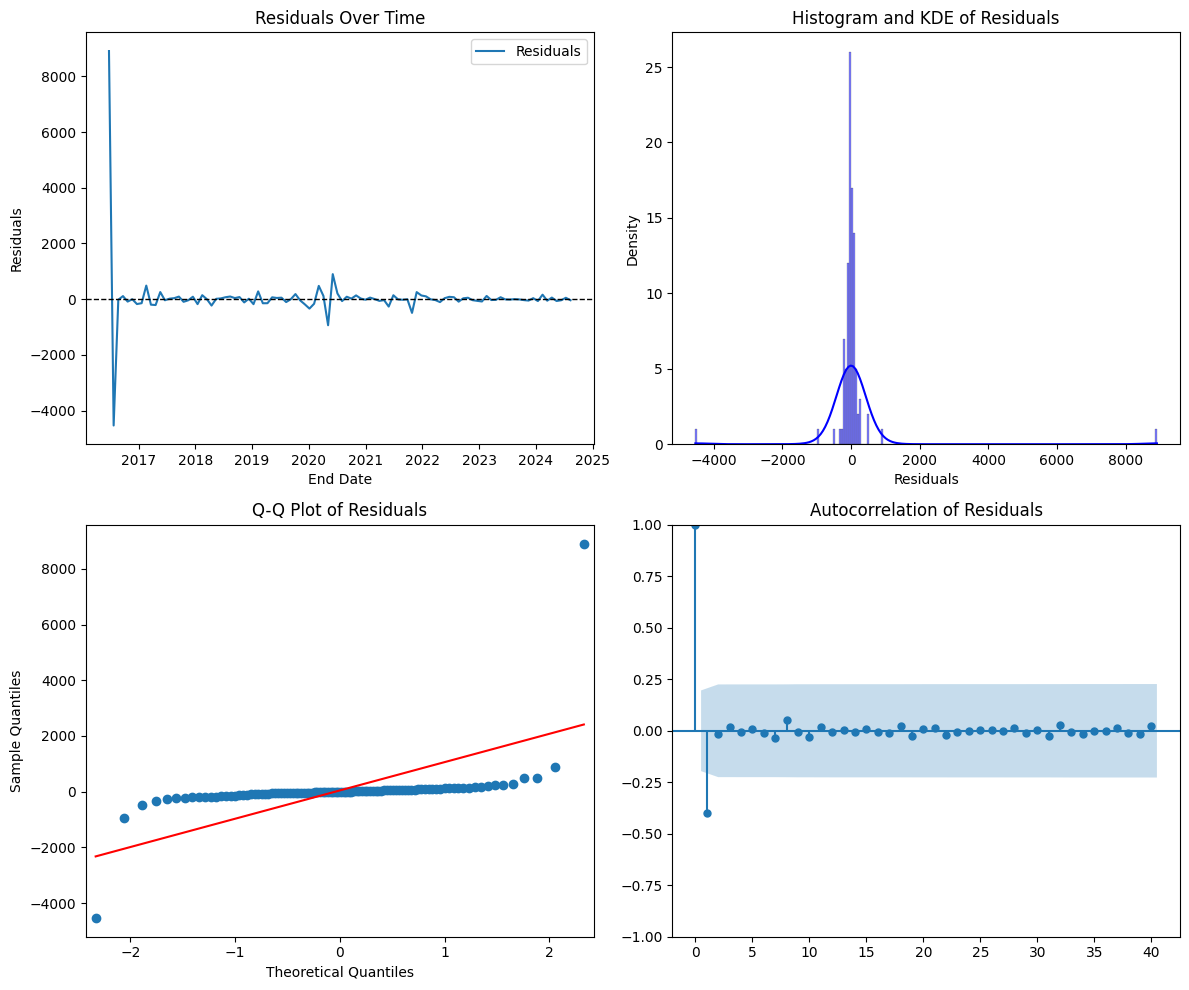

In [398]:
# Calculate residuals
residuals = results.resid

# Set up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Residuals over time
axs[0, 0].plot(data['End Date'], residuals, label='Residuals')
axs[0, 0].axhline(0, linestyle='--', color='black', linewidth=1)
axs[0, 0].set_title('Residuals Over Time')
axs[0, 0].set_xlabel('End Date')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].legend()

# Histogram and KDE plot of residuals
sns.histplot(residuals, kde=True, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('Histogram and KDE of Residuals')
axs[0, 1].set_xlabel('Residuals')
axs[0, 1].set_ylabel('Density')

# Q-Q plot of residuals
sm.qqplot(residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of Residuals')

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[1, 1])
axs[1, 1].set_title('Autocorrelation of Residuals')

# Adjust layout
plt.tight_layout()
plt.show()

I am also going to look at the model trained on the exogenous variables: admission_count and covid_event. This model didn't have the smallest average OOS metrics but it did have a smaller AIC than the model just trained on admission_count.

In [404]:
future_exog_covid = pd.Series(index = np.arange(len(exog),len(exog)+12), data = np.zeros(12))
type(future_exog_covid)

pandas.core.series.Series

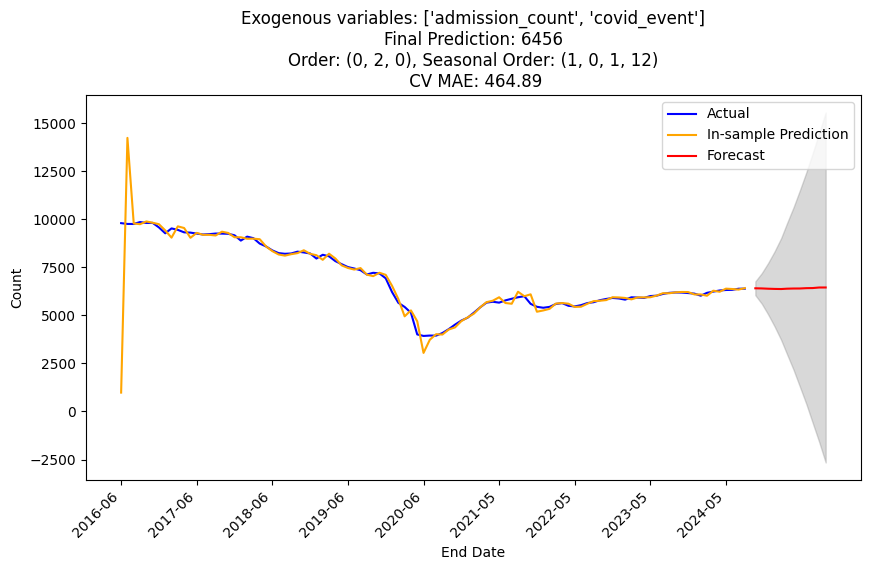

In [411]:
#redo predictions for arrests so we can use in the training of the doc admission model
target_var = 'ADP'
exog_vars = ['admission_count','covid_event']
data = joined_df[[target_var, 'End Date']].dropna()
y = data[target_var].dropna()
exog_adm = pd.concat([joined_df['admission_count'].dropna(),pd.Series(data = adm_model_results['model 2']['prediction'][0])],ignore_index=True)
exog_covid = joined_df['covid_event']
exog_covid.at[-1] = 0
exog = pd.concat([exog_adm,exog_covid], axis = 1)
future_exog_covid = pd.Series(index = np.arange(len(exog),len(exog)+12), data = np.zeros(12))
future_exog_adm = pd.Series(index = np.arange(len(exog),len(exog)+12), data = adm_model_results['model 2']['prediction'][1:])
future_exog = pd.concat([future_exog_adm,future_exog_covid], axis = 1)
# Ensure the exog variable has the same index as the target variable
exog = exog.loc[y.index]
    
# Extract the best model parameters
best_params = adp_models_results['model 4']['model params']
order, seasonal_order = best_params

# Fit the model to the entire dataset
model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

# In-sample prediction
in_sample_pred = results.predict(start=0, end=len(y)-1, exog=exog)

forecast = results.get_forecast(steps=12, exog=future_exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

#plot
plt.figure(figsize = (10,5))     
# Plot the actual data
plt.plot(data['End Date'], y, label='Actual', color='blue')
# Plot the in-sample prediction
plt.plot(data['End Date'], in_sample_pred, label='In-sample Prediction', color='orange')

# Plot the forecast
future_dates = pd.date_range(start=data['End Date'].iloc[-1] + pd.Timedelta(days=30), periods=12, freq='M')
plt.plot(future_dates, forecast_mean, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=0.3)

# Set title and labels, including model parameters and MAE
title = f"Exogenous variables: {exog_vars}\nFinal Prediction: {round(forecast_mean.iloc[-1])}\nOrder: {order}, Seasonal Order: {seasonal_order}\n CV MAE: {mae:.2f}"
plt.title(title)
plt.xlabel('End Date')
plt.ylabel('Count')

# Set x-ticks and rotate labels
plt.xticks(ticks = joined_df['End Date'][::12], labels = joined_df['End Date'][::12].dt.strftime('%Y-%m'), rotation=45, ha='right')

plt.legend(loc='upper right')
plt.show()

first degree diff = y_t - y_t-1

second degree diff = (first degree diff)_t - (first degree diff)_t-1

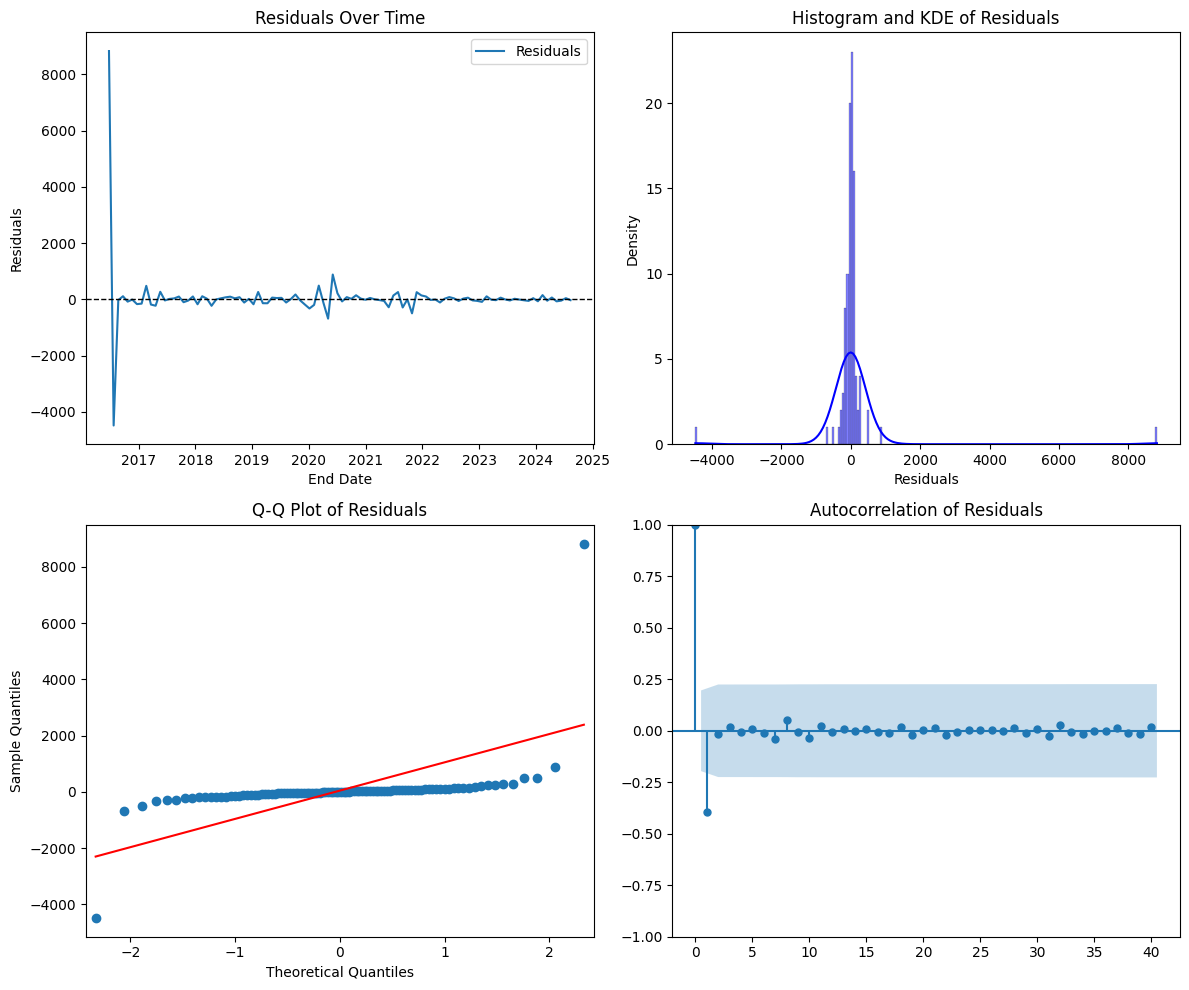

In [412]:
#plot residuals
residuals = results.resid

# Set up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Residuals over time
axs[0, 0].plot(data['End Date'], residuals, label='Residuals')
axs[0, 0].axhline(0, linestyle='--', color='black', linewidth=1)
axs[0, 0].set_title('Residuals Over Time')
axs[0, 0].set_xlabel('End Date')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].legend()

# Histogram and KDE plot of residuals
sns.histplot(residuals, kde=True, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('Histogram and KDE of Residuals')
axs[0, 1].set_xlabel('Residuals')
axs[0, 1].set_ylabel('Density')

# Q-Q plot of residuals
sm.qqplot(residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of Residuals')

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[1, 1])
axs[1, 1].set_title('Autocorrelation of Residuals')

# Adjust layout
plt.tight_layout()
plt.show()

OG: Data output was 6756 with CI of 1920 and 11591. order (2,2,0) and seasonal order of (0,0,0,12)

Most up to date model (7/28): Data output was 6585 with CI of 1886 and 11283. order (2,2,0) and seasonal order of (0,0,0,12)

The original dictionary for the ARIMA model parameters active on the webstie (As of 7/28) is:

`arima_dict = {
        "admission_count": {"order": [0, 1, 0], "seasonal_order": [1, 0, 0, 12]},
        "total_felony_crimes": {"order": [1, 1, 0], "seasonal_order": [2, 0, 2, 12]},
        "total_felony_arrest": {"order": [2, 1, 0], "seasonal_order": [1, 0, 0, 12]},     
        "Total Population": {"order": [2, 2, 0], "seasonal_order": [0, 0, 0, 12]}
    }
`

The results from this notebook would create a dictionary for the ARIMA model parameters as follows:

`
arima_dict = {
    "nonviolent_felony_crimes": {"order": [1, 1, 1], "seasonal_order": [1, 0, 0, 12]},
    "violent_felony_crimes": {"order": [1, 0, 0], "seasonal_order": [1, 0, 1, 12]},
    "total_misdemeanor_crimes": {"order": [2, 1, 2], "seasonal_order": [1, 0, 0, 12]},
    "total_nonviolent_arrest": {"order": [2, 1, 0], "seasonal_order": [1, 0, 1, 12]},     
    "total_violent_arrest": {"order": [1, 1, 2], "seasonal_order": [0, 0, 0, 12]},     
    "total_misdemeanor_arrest": {"order": [1, 1, 2], "seasonal_order": [1, 0, 0, 12]},     
    "admission_count": {"order": [2, 1, 2], "seasonal_order": [1, 0, 0, 12]},
    "Total Population": {"order": [2, 2, 0], "seasonal_order": [0, 0, 0, 12]}
}
`

# Residual Plots

**Explanation of the Diagnostic Plots:**

1. Residuals Over Time: This plot shows the residuals over time, which helps to identify any patterns or trends. Ideally, the residuals should be randomly distributed around zero.

2. Histogram and KDE Plot: This shows the distribution of the residuals, with a kernel density estimate (KDE) overlay. It helps to assess if the residuals follow a normal distribution.

3. Q-Q Plot: This plot compares the quantiles of the residuals with the quantiles of a normal distribution. If the residuals are normally distributed, the points should lie along the line.

4. Autocorrelation Function (ACF) Plot: This plot shows the autocorrelation of the residuals at different lags. Ideally, there should be no significant autocorrelation in the residuals (i.e., the autocorrelations should be close to zero for all lags).

By running this code, you'll be able to visualize the residuals and check if they meet the assumptions necessary for the SARIMA model.

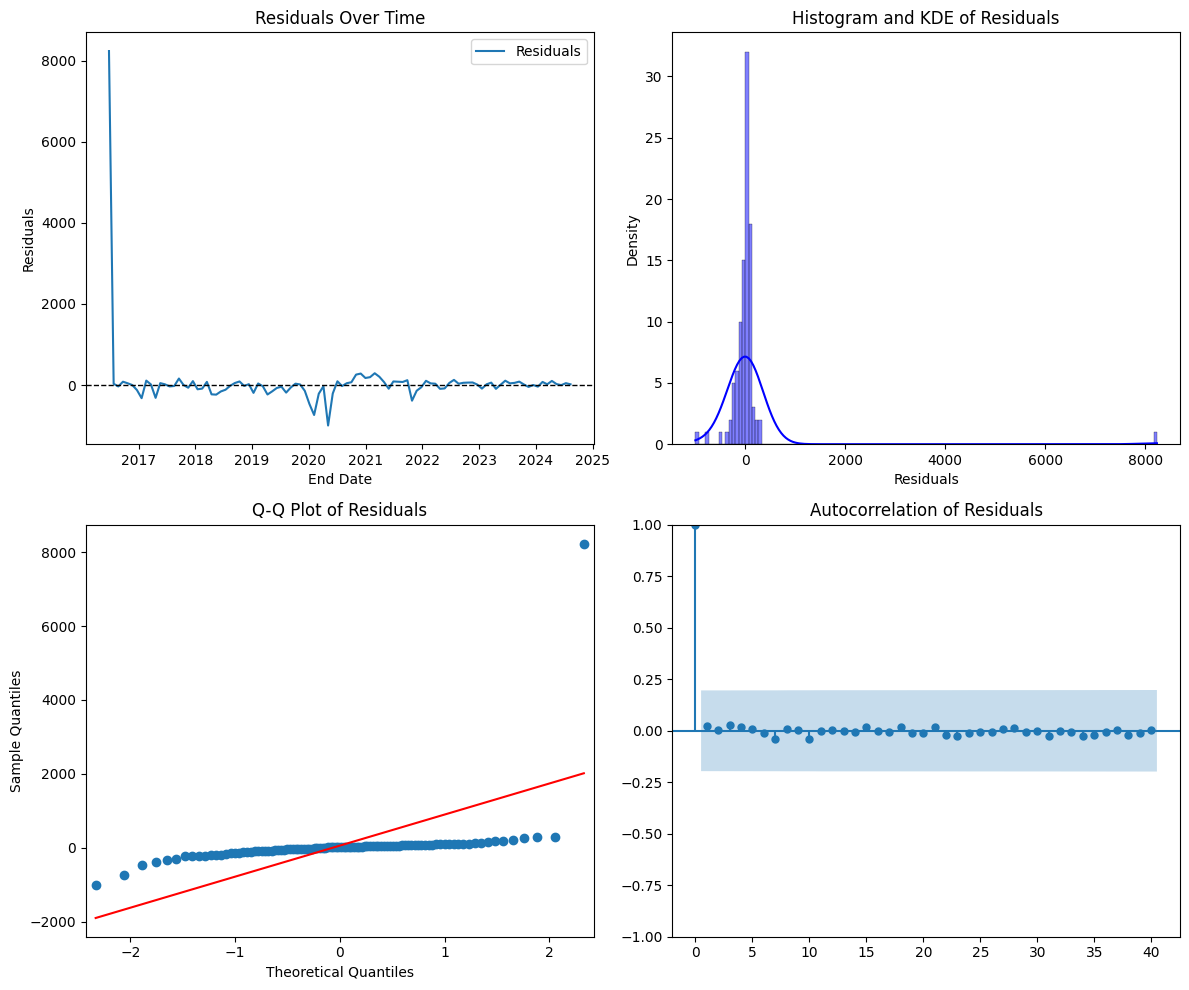

In [331]:
#plot diagnostics
import seaborn as sns
from scipy import stats

# Calculate residuals
residuals = results.resid

# Set up the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Residuals over time
axs[0, 0].plot(data['End Date'], residuals, label='Residuals')
axs[0, 0].axhline(0, linestyle='--', color='black', linewidth=1)
axs[0, 0].set_title('Residuals Over Time')
axs[0, 0].set_xlabel('End Date')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].legend()

# Histogram and KDE plot of residuals
sns.histplot(residuals, kde=True, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('Histogram and KDE of Residuals')
axs[0, 1].set_xlabel('Residuals')
axs[0, 1].set_ylabel('Density')

# Q-Q plot of residuals
sm.qqplot(residuals, line='s', ax=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of Residuals')

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[1, 1])
axs[1, 1].set_title('Autocorrelation of Residuals')

# Adjust layout
plt.tight_layout()
plt.show()
